In [14]:
import settings
from tqdm import tqdm
import json
import os
from process_sentinel2 import Mask, DayDataGenerator, DayData
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

### Define variables

In [3]:
DATA_PATH = settings.data_path
DATE_FORMAT = '%Y-%m-%d'
START_DATE = '2016-12-21'
END_DATE_NEW = '2022-04-20'
END_DATE_OLD = '2021-04-20'
END_DATE = END_DATE_OLD
MASK_PATH = "water_mask"

TA_coords = [(-34.829637, -55.042053)]

In [3]:
cisne_coords = [(-34.840706,-55.124542),
                (-34.840874,-55.124161),
                (-34.840958,-55.123714),
                (-34.841045,-55.123295),
                (-34.841148,-55.122890),
                (-34.841213,-55.122463),
                (-34.841267,-55.122021),
                (-34.841263,-55.121574),
                (-34.841316,-55.121098),
                (-34.841351,-55.120655),
                (-34.841373,-55.120228),
                (-34.841446,-55.119766),
                (-34.841412,-55.119339),
                (-34.841366,-55.118900),
                (-34.841270,-55.118450),
                (-34.841190,-55.117992),
                (-34.841217,-55.117546),
                (-34.841038,-55.117142),
                (-34.840878,-55.116745),
                (-34.840683,-55.116371),
                (-34.840454,-55.116020),
                (-34.840191,-55.115730),
                (-34.839989,-55.115360),
                (-34.839691,-55.115154),
                (-34.841896,-55.124554),
                (-34.842670,-55.124363),
                (-34.843388,-55.124084),
                (-34.844120,-55.123917),
                (-34.844803,-55.123581),
                (-34.845470,-55.123329),
                (-34.845757,-55.122528),
                (-34.846046,-55.121731),
                (-34.846363,-55.120941),
                (-34.846489,-55.120060),
                (-34.847328,-55.118622),
                (-34.848049,-55.118713),
                (-34.848778,-55.118721),
                (-34.848412,-55.117973),
                (-34.848007,-55.117233),
                (-34.848095,-55.116329),
                (-34.848179,-55.115429),
                (-34.848244,-55.114578),
                (-34.848476,-55.113739),
                (-34.848526,-55.112934),
                (-34.848301,-55.112099),
                (-34.847683,-55.111664),
                (-34.847027,-55.111271),
                (-34.846401,-55.110752),
                (-34.845741,-55.110382),
                (-34.844952,-55.110188),
                (-34.844261,-55.110210),
                (-34.843727,-55.110916),
                (-34.843151,-55.111576)]
print(len(cisne_coords))

53


### Make instance of data generator

In [4]:
data_generator = DayDataGenerator(START_DATE, END_DATE, DATE_FORMAT, DATA_PATH, skip_invalid=True)
len(data_generator)

81

### Load sample day

In [6]:
sample_day = DayData(os.path.join(settings.data_path, "2020-01-11", "acolite_output"))

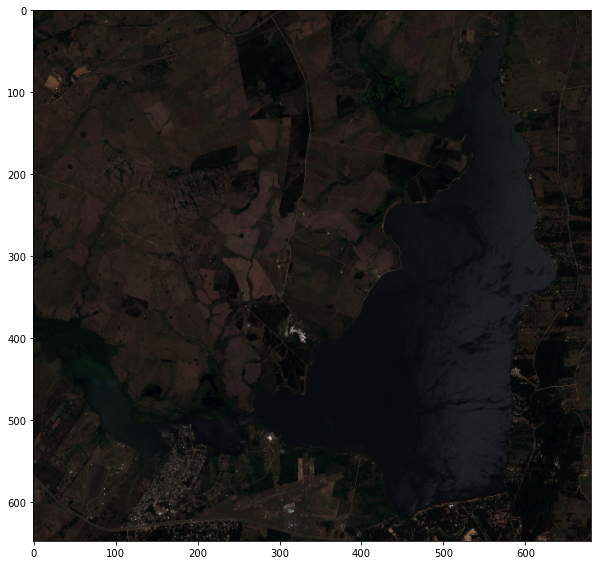

In [7]:
#sample_day.paint_coords(cisne_coords, (255, 255, 0), radius=1)
sample_day.show_rgb()
#plt.savefig("cisnes_sample_points.png", dpi=200, bbox_inches='tight')

### Load water mask

In [5]:
mask = Mask(MASK_PATH)
#mask.reduce_mask()

print("Pixel count:", mask.get_pixel_count())

Pixel count: 79726


### Display mask in sample day

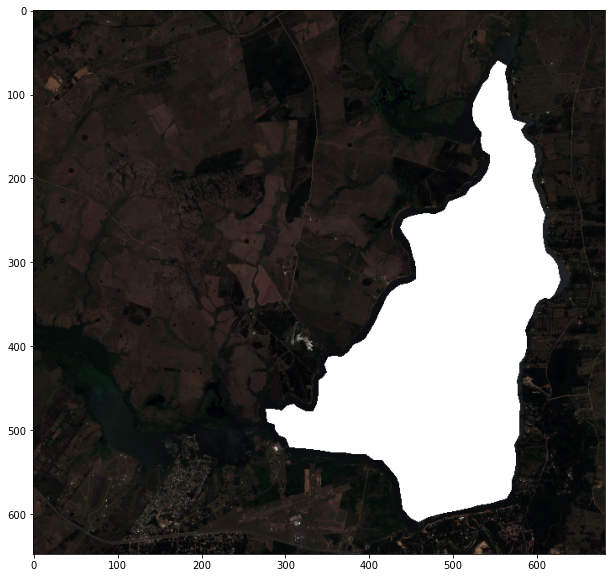

In [8]:
#sample_day = DayData(os.path.join(settings.data_path, "2020-05-30", "acolite_output"))
fig = plt.figure(figsize=(20,10))
#sample_day.paint_coords(cisne_coords, (0, 0, 255), radius=1)
rgb_with_mask = mask.display_mask_img(sample_day.rgb)
plt.imshow(rgb_with_mask)
plt.savefig("cisnes_with_mask.png", dpi=200, bbox_inches='tight')
plt.show()

### Tag image cloudiness

levels of cloud:

0) Clear

1) minimum clouds over the lake

2) medium amount of clouds

3) too cloudy to be any good


In [6]:
# from IPython.display import clear_output
# import time
# START_DATE = '2021-03-01'
# END_DATE = '2022-04-20'
# data_generator = DayDataGenerator(START_DATE, END_DATE, DATE_FORMAT, DATA_PATH, tagging=True)
# retag = False

# for day in data_generator:
#     print(day.date)
#     print(day.metadata)
#     current_metadata = day.metadata
#     if current_metadata != {} and not retag:
#         time.sleep(0.1)
#         clear_output(wait=True)
#         continue
#     # display rgb of day
#     fig = plt.figure(figsize=(20,10))
#     plt.imshow(mask.display_mask_contour(day.rgb))
#     plt.show()
#     # get user input
#     user_input = input()
#     # overwrite with changes
#     with open(day.metadata_path, 'w') as fp:
#         current_metadata["cloud level"] = user_input
#         json.dump(current_metadata, fp)
#     clear_output(wait=True)

Error in 2022-04-13: [Errno 2] No such file or directory: '/home/enzo_tng/cianobacterias/data/2022-04-13/acolite_output'


## Clustering

### Make NDCI numpy array dataset

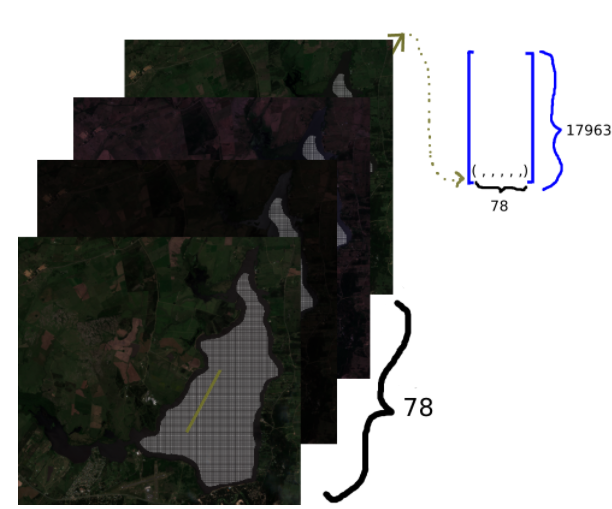

In [9]:
# make instance of data generator that skips invalid dates
data_generator = DayDataGenerator(START_DATE, END_DATE, DATE_FORMAT, DATA_PATH, skip_invalid=True)
# make array to store ndci of every valid day
ndci_dataset_array = np.zeros((sample_day.rgb.shape[0], sample_day.rgb.shape[1], len(data_generator)))
H, W, D = ndci_dataset_array.shape
# list of dates for ndci_dataset_array
dates_list = []
# progress bar
pbar = tqdm(total=len(data_generator))
for d, day in enumerate(data_generator):
    ndci_day_array = day.get_NDCI()
    dates_list.append(str(day.date.date()))
    ndci_dataset_array[:, :, d] = ndci_day_array
    pbar.update(1)
pbar.close()

100%|██████████| 81/81 [00:12<00:00,  6.62it/s]


### Make clustering dataset

In [11]:
clustering_dataset = []
indexes = []
pbar = tqdm(total=mask.height*mask.width)
for i in range(mask.height):
    for j in range(mask.width):
        if mask.array[i, j] == 1:
            clustering_dataset.append(list(ndci_dataset_array[i, j, :]))
            indexes.append([i, j])
        pbar.update(1)
pbar.close()
clustering_data = {}
clustering_data["data"] = clustering_dataset
clustering_data["positions"] = indexes
clustering_data["dates"] = dates_list

100%|██████████| 441288/441288 [00:02<00:00, 177976.97it/s]


### Save to json

In [9]:
# with open("clustering_dataset_20m.json", 'w') as f:
#     json.dump(json_dictionary, f)

### Load clustering dataset

In [10]:
# import json

# with open("clustering_dataset_20m.json") as f:
#     clustering_data = json.load(f)

# Fit clustering data

In [12]:
X = clustering_data["data"]

### K-means


  0%|          | 0/6 [01:41<?, ?it/s].13s/it]

100%|██████████| 6/6 [01:13<00:00, 12.26s/it]


[10438.681983201868, 7601.698288307509, 6780.713291417113, 6190.7712893914395, 5878.012680455418, 5617.52457521682]


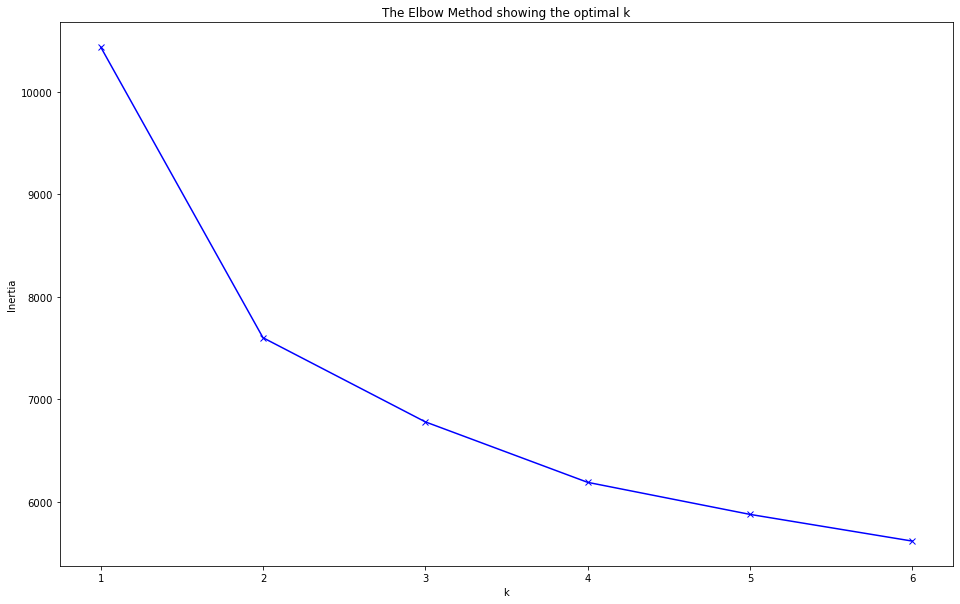

In [15]:
from sklearn.cluster import KMeans

def draw_text(text,img, x , y, color = (255,255,255)):
    font = cv2.FONT_HERSHEY_SIMPLEX
    org = (110, 25)
    fontScale = 1
    thickness = 2
    cv2.putText(img, text, (x, y), font, 1, color, thickness, cv2.LINE_AA)


kmeans_save_path = "K-means"
    
inertias = []
K = range(1,7)
clusters_colors = [[240, 15, 15], [240,163,255], [153,63,0], [43,206,72], [255,204,153], [31, 49, 209], [255,255,255]]
pbar = tqdm(total=len(K))
for k in K:
    clustering = KMeans(n_clusters=k)
    clustering.fit(X)
    inertias.append(clustering.inertia_)
    
    #sample_day = DayData(os.path.join("sample_data", "2021-01-25"))
    sample_day = DayData(os.path.join(settings.data_path, "2021-02-26", "acolite_output"))
    unique_labels = list(set(clustering.labels_))
                
    # load image without clusters
    final_img = sample_day.rgb.copy()
    labels_arr = np.ones((final_img.shape[0], final_img.shape[1]), dtype=np.uint8)*254
    # itearte over a list containing the label of every pixel in the lagoon and paint it on map
    for i, label in enumerate(clustering.labels_):
        if label == -1:
            continue
        label_position = clustering_data["positions"][i]
        final_img[label_position[0], label_position[1], :] = clusters_colors[label]    
        labels_arr[label_position[0], label_position[1]] = int(label)

    #draw legends
    legend_position = {"x": 50, "y": 50}
    for label in unique_labels:
        draw_text("cluster " + str(label), final_img, legend_position["x"], legend_position["y"], color=clusters_colors[label])
        legend_position["y"] = legend_position["y"] + 50    

    # make and save map with clusters
    clusters_image_path = os.path.join(kmeans_save_path, str(k) + "_clusters.png")
    #fig = plt.figure(figsize=(20,20))
    #plt.imshow(final_img)
    #plt.savefig(clusters_image_path, dpi=200, bbox_inches='tight')
    #plt.close(fig)

    #get NDCI mean and std of every cluster in every day
    results = []
    for d in range(D):
        day_results = {}
        day_results["date"] = clustering_data["dates"][d]
        day_ndci = ndci_dataset_array[:, :, d]

        for label in unique_labels:
            y, x = np.where(labels_arr == label)
            label_ndci_values = []
            for i, j in zip(y, x):
                label_ndci_values.append(day_ndci[i, j])
            label_ndci_values = np.array(label_ndci_values)
            label_mean = np.mean(label_ndci_values)
            label_std = np.std(label_ndci_values)

            day_results[label] = {"mean": label_mean, "std": label_std}
        results.append(day_results)

    # make and save image with cluster mean time series
    day_indexes = range(1, len(results)+1)
    fig = plt.figure(figsize=(40,20))
    for i, label in enumerate(unique_labels):
        label_means = [d[label]["mean"] for d in results]
        #label_stds = [d[label]["std"] for d in results]
        #plt.plot(day_indexes, label_means, label=str(label) + " mean")
        color = tuple([c/255 for c in clusters_colors[label]])
        plt.plot([d["date"] for d in results], label_means, label=str(label), color=color)
        #plt.plot(day_indexes, label_stds, label=str(label) + " std")

    plt.xlabel('date')
    plt.xticks(np.arange(0, len(results), 1.0))
    # Set the y axis label of the current axis.
    plt.ylabel('cluster NDCI mean')
    # Set a title of the current axes.
    plt.title('Time series of NDCI mean for every cluster')
    # put date in angle to read better
    fig.autofmt_xdate()
    # show a legend on the plot
    plt.legend(prop={'size': 40})
    # save figure
    #timeseries_image_path = os.path.join(kmeans_save_path, str(k) + "_clusters_timeseries.png")
    #plt.savefig(timeseries_image_path, dpi=100, bbox_inches='tight')
    plt.close(fig)

    
    pbar.update(1)
pbar.close()
print(inertias)

inertias_image_path = os.path.join(kmeans_save_path, "inertias.png")
plt.figure(figsize=(16,10))
plt.plot(K, inertias, 'bx-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('The Elbow Method showing the optimal k')
plt.savefig(inertias_image_path, dpi=100, bbox_inches='tight')
plt.show()

### Agglomerative clustering

In [14]:
linkage_methods = ["single", "complete", "average", "ward"]

metrics = ["euclidean", "cityblock", "cosine"]

Methods ‘centroid’, ‘median’, and ‘ward’ are correctly defined only if Euclidean pairwise metric is used.

In [66]:
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering

def draw_text(text,img, x , y, color = (255,255,255)):
    font = cv2.FONT_HERSHEY_SIMPLEX
    org = (110, 25)
    fontScale = 1
    thickness = 2
    cv2.putText(img, text, (x, y), font, 1, color, thickness, cv2.LINE_AA)

output_directory = "Agglomerative_clustering"
save_matrix = True
overwrite = False

sample_day = DayData(os.path.join("sample_data", "2021-01-25"))

clusters_colors = [[240, 15, 15], [240,163,255], [153,63,0], [43,206,72], [255,204,153], [31, 49, 209], [255,255,255]]

H, W, D = ndci_dataset_array.shape

for linkage_method in linkage_methods:
    for distance_metric in metrics:
        if linkage_method == "ward" and distance_metric != "euclidean":
            continue
        print("processing " + linkage_method + " linkage method with " + distance_metric + " metric")
        #create directory if doesn't exist already
        agglomerative_clustering_directory = os.path.join(output_directory, linkage_method, distance_metric)
        if not os.path.isdir(agglomerative_clustering_directory):
            os.makedirs(agglomerative_clustering_directory)
            
            # make linkage matrix or load if already stored
            try:
                linkage_matrix = np.load(os.path.join(agglomerative_clustering_directory, "linkage_matrix.npy"))

            except FileNotFoundError:
                linkage_matrix = sch.linkage(X, method=linkage_method, metric=distance_metric)
                if save_matrix == True:
                    np.save(os.path.join(agglomerative_clustering_directory, "linkage_matrix.npy"), linkage_matrix)

            # make and save dendogram
            fig = plt.figure(figsize=(20,13))
            dendrogram = sch.dendrogram(linkage_matrix, truncate_mode='level', p=3)
            plt.title(linkage_method + ' linkage dendrogram')
            plt.xlabel('Number of points in node')
            plt.ylabel(distance_metric + ' distances')
            plt.savefig(os.path.join(agglomerative_clustering_directory, "dendogram.jpg"))
            plt.close(fig)
            #plt.show()
            
            # process dataset for different amount of clusters and store things
            for n_clusters in [3, 4, 5, 6]:
                clustering = AgglomerativeClustering(n_clusters=n_clusters, affinity=distance_metric, linkage=linkage_method).fit(X)
                unique_labels = list(set(clustering.labels_))
                
                #image without clusters
                final_img = sample_day.rgb.copy()
                labels_arr = np.ones((final_img.shape[0], final_img.shape[1]), dtype=np.uint8)*254
                # itearte over a list containing the label of every pixel in the lagoon and paint it on map
                for i, label in enumerate(clustering.labels_):
                    if label == -1:
                        continue
                    label_position = clustering_data["positions"][i]
                    final_img[label_position[0], label_position[1], :] = clusters_colors[label]    
                    labels_arr[label_position[0], label_position[1]] = int(label)
                    
                #draw legends
                legend_position = {"x": 50, "y": 50}
                for label in unique_labels:
                    draw_text("cluster " + str(label), final_img, legend_position["x"], legend_position["y"], color=clusters_colors[label])
                    legend_position["y"] = legend_position["y"] + 50    

                # make and save map with clusters
                clusters_image_path = os.path.join(agglomerative_clustering_directory, str(n_clusters) + "_clusters.png")
                fig = plt.figure(figsize=(20,10))
                plt.imshow(final_img)
                plt.savefig(clusters_image_path, dpi=200, bbox_inches='tight')
                plt.close(fig)
                    
                #get NDCI mean and std of every cluster in every day
                results = []
                for d in range(D):
                    day_results = {}
                    day_results["date"] = clustering_data["dates"][d]
                    day_ndci = ndci_dataset_array[:, :, d]

                    for label in unique_labels:
                        y, x = np.where(labels_arr == label)
                        label_ndci_values = []
                        for i, j in zip(y, x):
                            label_ndci_values.append(day_ndci[i, j])
                        label_ndci_values = np.array(label_ndci_values)
                        label_mean = np.mean(label_ndci_values)
                        label_std = np.std(label_ndci_values)

                        day_results[label] = {"mean": label_mean, "std": label_std}
                    results.append(day_results)

                # make and save image with cluster mean time series
                day_indexes = range(1, len(results)+1)
                fig = plt.figure(figsize=(40,20))
                for label in unique_labels:
                    label_means = [d[label]["mean"] for d in results]
                    #label_stds = [d[label]["std"] for d in results]
                    #plt.plot(day_indexes, label_means, label=str(label) + " mean")
                    color = tuple([c/255 for c in clusters_colors[label]])
                    plt.plot([d["date"] for d in results], label_means, label=str(label), color=color)
                    #plt.plot(day_indexes, label_stds, label=str(label) + " std")
                    
                plt.xlabel('date')
                plt.xticks(np.arange(1, len(results)+1, 1.0))
                # Set the y axis label of the current axis.
                plt.ylabel('cluster NDCI mean')
                # Set a title of the current axes.
                plt.title('Time series of NDCI mean for every cluster')
                # put date in angle to read better
                fig.autofmt_xdate()
                # show a legend on the plot
                plt.legend(prop={'size': 40})
                # save figure
                timeseries_image_path = os.path.join(agglomerative_clustering_directory, str(n_clusters) + "_clusters_timeseries")
                plt.savefig(timeseries_image_path, dpi=100, bbox_inches='tight')
                plt.close(fig)

processing ward linkage method with euclidean metric
processing complete linkage method with euclidean metric
processing complete linkage method with cityblock metric
processing complete linkage method with cosine metric
processing single linkage method with euclidean metric
processing single linkage method with cityblock metric
processing single linkage method with cosine metric
processing average linkage method with euclidean metric
processing average linkage method with cityblock metric
processing average linkage method with cosine metric


### Spectral

In [64]:
from sklearn.cluster import SpectralClustering

def draw_text(text,img, x , y, color = (255,255,255)):
    font = cv2.FONT_HERSHEY_SIMPLEX
    org = (110, 25)
    fontScale = 1
    thickness = 2
    cv2.putText(img, text, (x, y), font, 1, color, thickness, cv2.LINE_AA)


spectral_save_path = "Spectral"

K = range(3,7)
clusters_colors = [[240, 15, 15], [240,163,255], [153,63,0], [43,206,72], [255,204,153], [31, 49, 209], [255,255,255]]
pbar = tqdm(total=7)
for k in K:
    clustering = SpectralClustering(n_clusters=k)
    clustering.fit(X)
    
    sample_day = DayData(os.path.join("sample_data", "2021-01-25"))
    unique_labels = list(set(clustering.labels_))
    
    # load image without clusters
    final_img = sample_day.rgb.copy()
    labels_arr = np.ones((final_img.shape[0], final_img.shape[1]), dtype=np.uint8)*254
    # itearte over a list containing the label of every pixel in the lagoon and paint it on map
    for i, label in enumerate(clustering.labels_):
        if label == -1:
            continue
        label_position = clustering_data["positions"][i]
        final_img[label_position[0], label_position[1], :] = clusters_colors[label]    
        labels_arr[label_position[0], label_position[1]] = int(label)

    #draw legends
    legend_position = {"x": 50, "y": 50}
    for label in unique_labels:
        draw_text("cluster " + str(label), final_img, legend_position["x"], legend_position["y"], color=clusters_colors[label])
        legend_position["y"] = legend_position["y"] + 50    

    # make and save map with clusters
    clusters_image_path = os.path.join(spectral_save_path, str(k) + "_clusters.png")
    fig = plt.figure(figsize=(20,20))
    plt.imshow(final_img)
    plt.savefig(clusters_image_path, dpi=200, bbox_inches='tight')
    plt.close(fig)

    #get NDCI mean and std of every cluster in every day
    results = []
    for d in range(D):
        day_results = {}
        day_results["date"] = clustering_data["dates"][d]
        day_ndci = ndci_dataset_array[:, :, d]

        for label in unique_labels:
            y, x = np.where(labels_arr == label)
            label_ndci_values = []
            for i, j in zip(y, x):
                label_ndci_values.append(day_ndci[i, j])
            label_ndci_values = np.array(label_ndci_values)
            label_mean = np.mean(label_ndci_values)
            label_std = np.std(label_ndci_values)

            day_results[label] = {"mean": label_mean, "std": label_std}
        results.append(day_results)

    # make and save image with cluster mean time series
    day_indexes = range(1, len(results)+1)
    fig = plt.figure(figsize=(40,20))
    for i, label in enumerate(unique_labels):
        label_means = [d[label]["mean"] for d in results]
        #label_stds = [d[label]["std"] for d in results]
        #plt.plot(day_indexes, label_means, label=str(label) + " mean")
        color = tuple([c/255 for c in clusters_colors[label]])
        plt.plot([d["date"] for d in results], label_means, label=str(label), color=color)
        #plt.plot(day_indexes, label_stds, label=str(label) + " std")

    plt.xlabel('date')
    plt.xticks(np.arange(0, len(results), 1.0))
    # Set the y axis label of the current axis.
    plt.ylabel('cluster NDCI mean')
    # Set a title of the current axes.
    plt.title('Time series of NDCI mean for every cluster')
    # put date in angle to read better
    fig.autofmt_xdate()
    # show a legend on the plot
    plt.legend(prop={'size': 40})
    # save figure
    timeseries_image_path = os.path.join(spectral_save_path, str(k) + "_clusters_timeseries.png")
    plt.savefig(timeseries_image_path, dpi=100, bbox_inches='tight')
    plt.close(fig)

    
    pbar.update(1)
pbar.close()

 57%|█████▋    | 4/7 [13:32<10:09, 203.09s/it]


### Choose clustering algorithm

In [20]:
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import SpectralClustering
from sklearn.cluster import OPTICS

clustering = KMeans(n_clusters=3, random_state=42).fit(X)
#clustering = AgglomerativeClustering(n_clusters=6, affinity='euclidean', linkage='ward').fit(X)
#clustering = SpectralClustering(n_clusters=3, assign_labels='discretize').fit(X)
#clustering = OPTICS(min_samples=100).fit(X)

### Display dendogram

In [ ]:
linkage_methods = ["ward", "complete", "single", "average"]
distance_metrics = ["euclidean", "cityblock", "cosine"]

linkage_method = linkage_methods[1]
distance_metric = distance_metrics[1]
linkage_matrix = sch.linkage(X, method=linkage_method, metric=distance_metric)

# make and save dendogram
fig = plt.figure(figsize=(20,13))
dendrogram = sch.dendrogram(linkage_matrix, truncate_mode='level', p=3)
plt.title(linkage_method + ' linkage dendrogram')
plt.xlabel('Number of points in node')
plt.ylabel(distance_metric + ' distances')
#plt.savefig(os.path.join(agglomerative_clustering_directory, "dendogram.jpg"))
#plt.close(fig)
plt.show()

### Display clusters

cluster labels: [0, 1, 2]


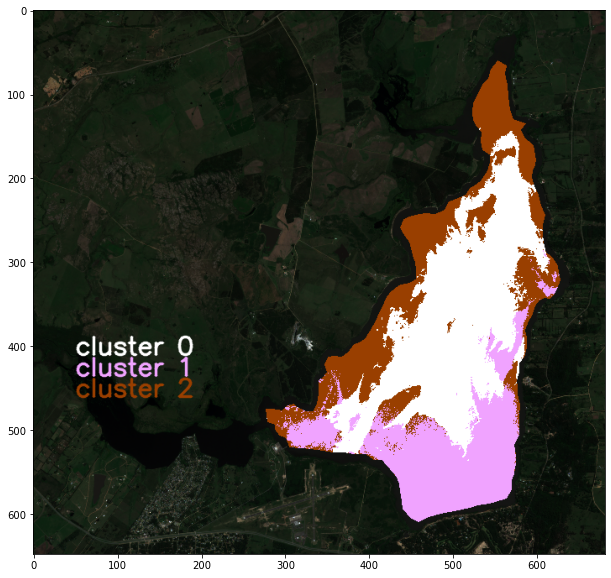

In [25]:
from process_sentinel2 import *
import random
import cv2

def draw_text(text,img, x , y, color = (255,255,255)):
    font = cv2.FONT_HERSHEY_SIMPLEX
    org = (110, 25)
    fontScale = 1
    thickness = 2
    cv2.putText(img, text, (x, y), font, 1, color, thickness, cv2.LINE_AA)

#sample_day = DayData(os.path.join("sample_data", "2021-01-25"))
sample_day = DayData(os.path.join(settings.data_path, "2021-02-26", "acolite_output"))
#sample_day.show_rgb()
final_img = sample_day.rgb.copy()
labels_arr = np.ones((final_img.shape[0], final_img.shape[1]), dtype=np.uint8)*254


clusters_colors = [[255,255,255], [240,163,255], [153,63,0], [43,206,72], [255,204,153], [31, 49, 209], [0, 0, 0]]

unique_labels = list(set(clustering.labels_))
print("cluster labels:", unique_labels)

# here I'm iterating over a list containing the label of every pixel in the lagoon
for i, label in enumerate(clustering.labels_):
    if label == -1:
        continue
    label_position = clustering_data["positions"][i]
    final_img[label_position[0], label_position[1], :] = clusters_colors[label]    
    labels_arr[label_position[0], label_position[1]] = int(label)

#draw legends
legend_position = {"x": 50, "y": 410}
for label in unique_labels:
    draw_text("cluster " + str(label), final_img, legend_position["x"], legend_position["y"], color=clusters_colors[label])
    legend_position["y"] = legend_position["y"] + 25    

fig = plt.figure(figsize=(20,10))
plt.imshow(final_img)
plt.savefig("prediction_data/kmeans_3/kmeans_3.png")
plt.show()

### Paint coords on top of clusters

100%|██████████| 53/53 [00:00<00:00, 330.35it/s]


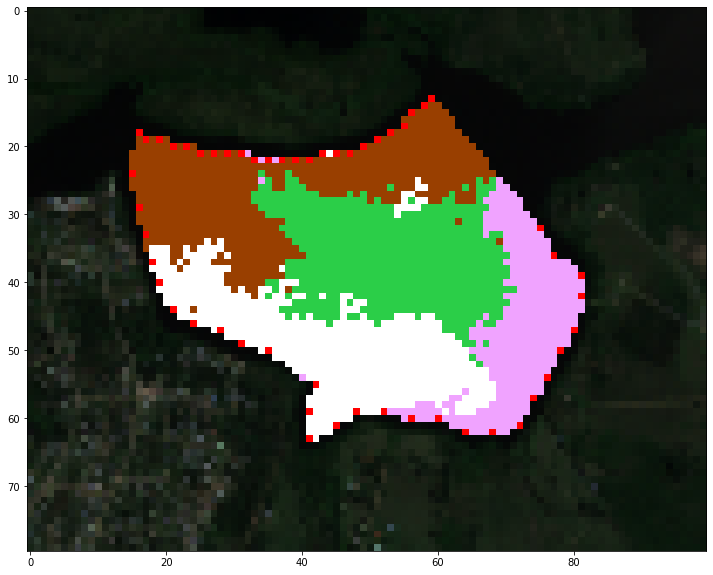

In [40]:
sample_day.rgb = final_img 
sample_day.paint_coords(cisne_coords, (255, 0, 0), radius=0)
#draw_text("Water samples", sample_day.rgb, 50, 600, color=(255, 0, 0))
fig = plt.figure(figsize=(20,10))
plt.imshow(final_img[480:560, 180:280,:])
plt.savefig("clusters_and_samples.png", dpi=200, bbox_inches='tight', pad_inches=0)
plt.show()

### Make pandas dataframe with mean and std of every cluster for every day

In [28]:
H, W, D = ndci_dataset_array.shape

results = []

pbar = tqdm(total=D)
for d in range(D):
    day_ndci = ndci_dataset_array[:, :, d]
#     day_results = {}
#     day_results["date"] = clustering_data["dates"][d]
    for label in unique_labels:
        day_results = {}
        #day_results["date"] = clustering_data["dates"][d]
        day_results["date"] = datetime.strptime(clustering_data["dates"][d], "%Y-%m-%d")
        y, x = np.where(labels_arr == label)
        label_ndci_values = []
        for i, j in zip(y, x):
            label_ndci_values.append(day_ndci[i, j])
        label_ndci_values = np.array(label_ndci_values)
        label_mean = np.mean(label_ndci_values)
        label_std = np.std(label_ndci_values)
        
        #day_results[label] = {"mean": label_mean, "std": label_std}
        day_results["mean_ndci"] = label_mean
        day_results["max_ndci"] = label_mean + 2*label_std
        day_results["min_ndci"] = label_mean - 2*label_std
        day_results["cluster"] = label
        results.append(day_results)
    pbar.update(1)            
pbar.close()

results_df = pd.DataFrame(results)
results_df.to_csv("prediction_data/kmeans_3/ndci_data.csv", index=False)
results_df

100%|██████████| 81/81 [00:05<00:00, 14.12it/s]


### Make cluster map

In [30]:
cluster_map = np.ones_like(mask.array)*80
for i, label in enumerate(clustering.labels_):
    if label == -1:
        continue
    label_position = clustering_data["positions"][i]
    cluster_map[label_position[0], label_position[1]] = label

# Visualization

### Load data from https://www.ambiente.gub.uy/oan/datos-abiertos/calidad-agua/

In [85]:
import csv

def load_cyano_concentration_csv(csv_path):
    agua_data = []
    with open(csv_path, newline='\n') as csvfile:
        spamreader = csv.reader(csvfile, delimiter=',')
        for i, row in enumerate(spamreader):
            day_measure = {} 
            if i==0:
                continue
            date_time = datetime.strptime(row[0][0:10], "%Y-%m-%d")
            day_measure["date"] = date_time
            
            cyano_value = row[2]
            day_measure["cyanobacteria"] = float(cyano_value)
            agua_data.append(day_measure)
    output = pd.DataFrame(agua_data)
    return output

agua_data = load_cyano_concentration_csv("agua_open_data(1).csv")
print(agua_data)

          date  cyanobacteria
0   2020-01-02        1150.00
1   2020-01-04       20731.00
2   2020-01-05       17521.00
3   2020-01-06        9943.00
4   2020-01-07       10401.00
..         ...            ...
162 2020-10-31        1083.00
163 2020-11-01          47.00
164 2020-11-02           5.96
165 2020-11-05           9.06
166 2021-02-04           1.77

[167 rows x 2 columns]


### Load data from Cisne measures and reformat it to:

| total chl | lat        | lon       | location |
|----------|------------|-----------|---------------|
| 54       | -34.842145 | -55.64641 | Sur 1         |

In [19]:
chl_th = 10
cisne_df_base = pd.read_csv('Laguna_Sauce_24-03-2020.csv', index_col=False)
data_reformatted = []
measures = cisne_df_base["measure"].values.tolist()
locations = cisne_df_base.columns.tolist()[1:]
for location_name in cisne_df_base.columns.tolist()[1:]:
    location_data_dict = {}
    for i, measure in enumerate(measures):
        location_data_dict[measure] = cisne_df_base[location_name][i]
    location_data_dict["location"] = location_name
    data_reformatted.append(location_data_dict)
cisne_df = pd.DataFrame(data_reformatted)
cisne_df = cisne_df[["Total chlorophyll concentration", "lat", "lon", "location"]]
cisne_df = cisne_df[cisne_df["Total chlorophyll concentration"] > chl_th]

### Get correlations

100%|██████████| 49/49 [04:07<00:00,  5.04s/it]


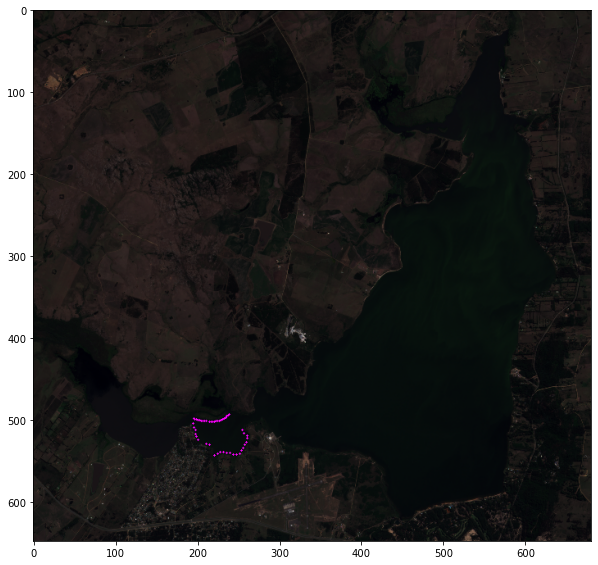

<Figure size 432x288 with 0 Axes>

In [46]:
import random

day_date = "2020-03-23"
day_data = DayData(os.path.join(settings.data_path, day_date, "acolite_output"))
date_index = clustering_data["dates"].index("2020-03-23")
locations = []
gts = []
predicted = []
predicted_ndci = []
pbar = tqdm(total=len(cisne_df))
for index, row in cisne_df.iterrows():
    gt_chl = row["Total chlorophyll concentration"]
    
    lat = row["lat"]
    lon = row["lon"]
    location = row["location"]
    
    location_y, location_x = day_data.get_pos_index(lat, lon)
    
    cluster = cluster_map[location_y, location_x]
    while cluster == 80:
        offsets = [0, 1, -1]
        cluster = cluster_map[location_y + random.choice(offsets), location_x + random.choice(offsets)]
    try:
        cluster_mean = results_df[(results_df["date"] == "2020-03-23") & (results_df["cluster"] == cluster)]["mean_ndci"].values[0]
    except:
        pbar.update(1)
        continue
    day_data.rgb = cv2.circle(day_data.rgb, (location_x, location_y), 1, [255, 0, 255], -1)
    point_ndci = ndci_dataset_array[location_y, location_x, date_index]
    predicted_ndci.append(point_ndci)
    predicted.append(cluster_mean)
    gts.append(gt_chl)
    locations.append(location)
    pbar.update(1)
pbar.close()
day_data.show_rgb()

/home/enzo_tng/anaconda3/envs/cyano_venv/lib/python3.6/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until


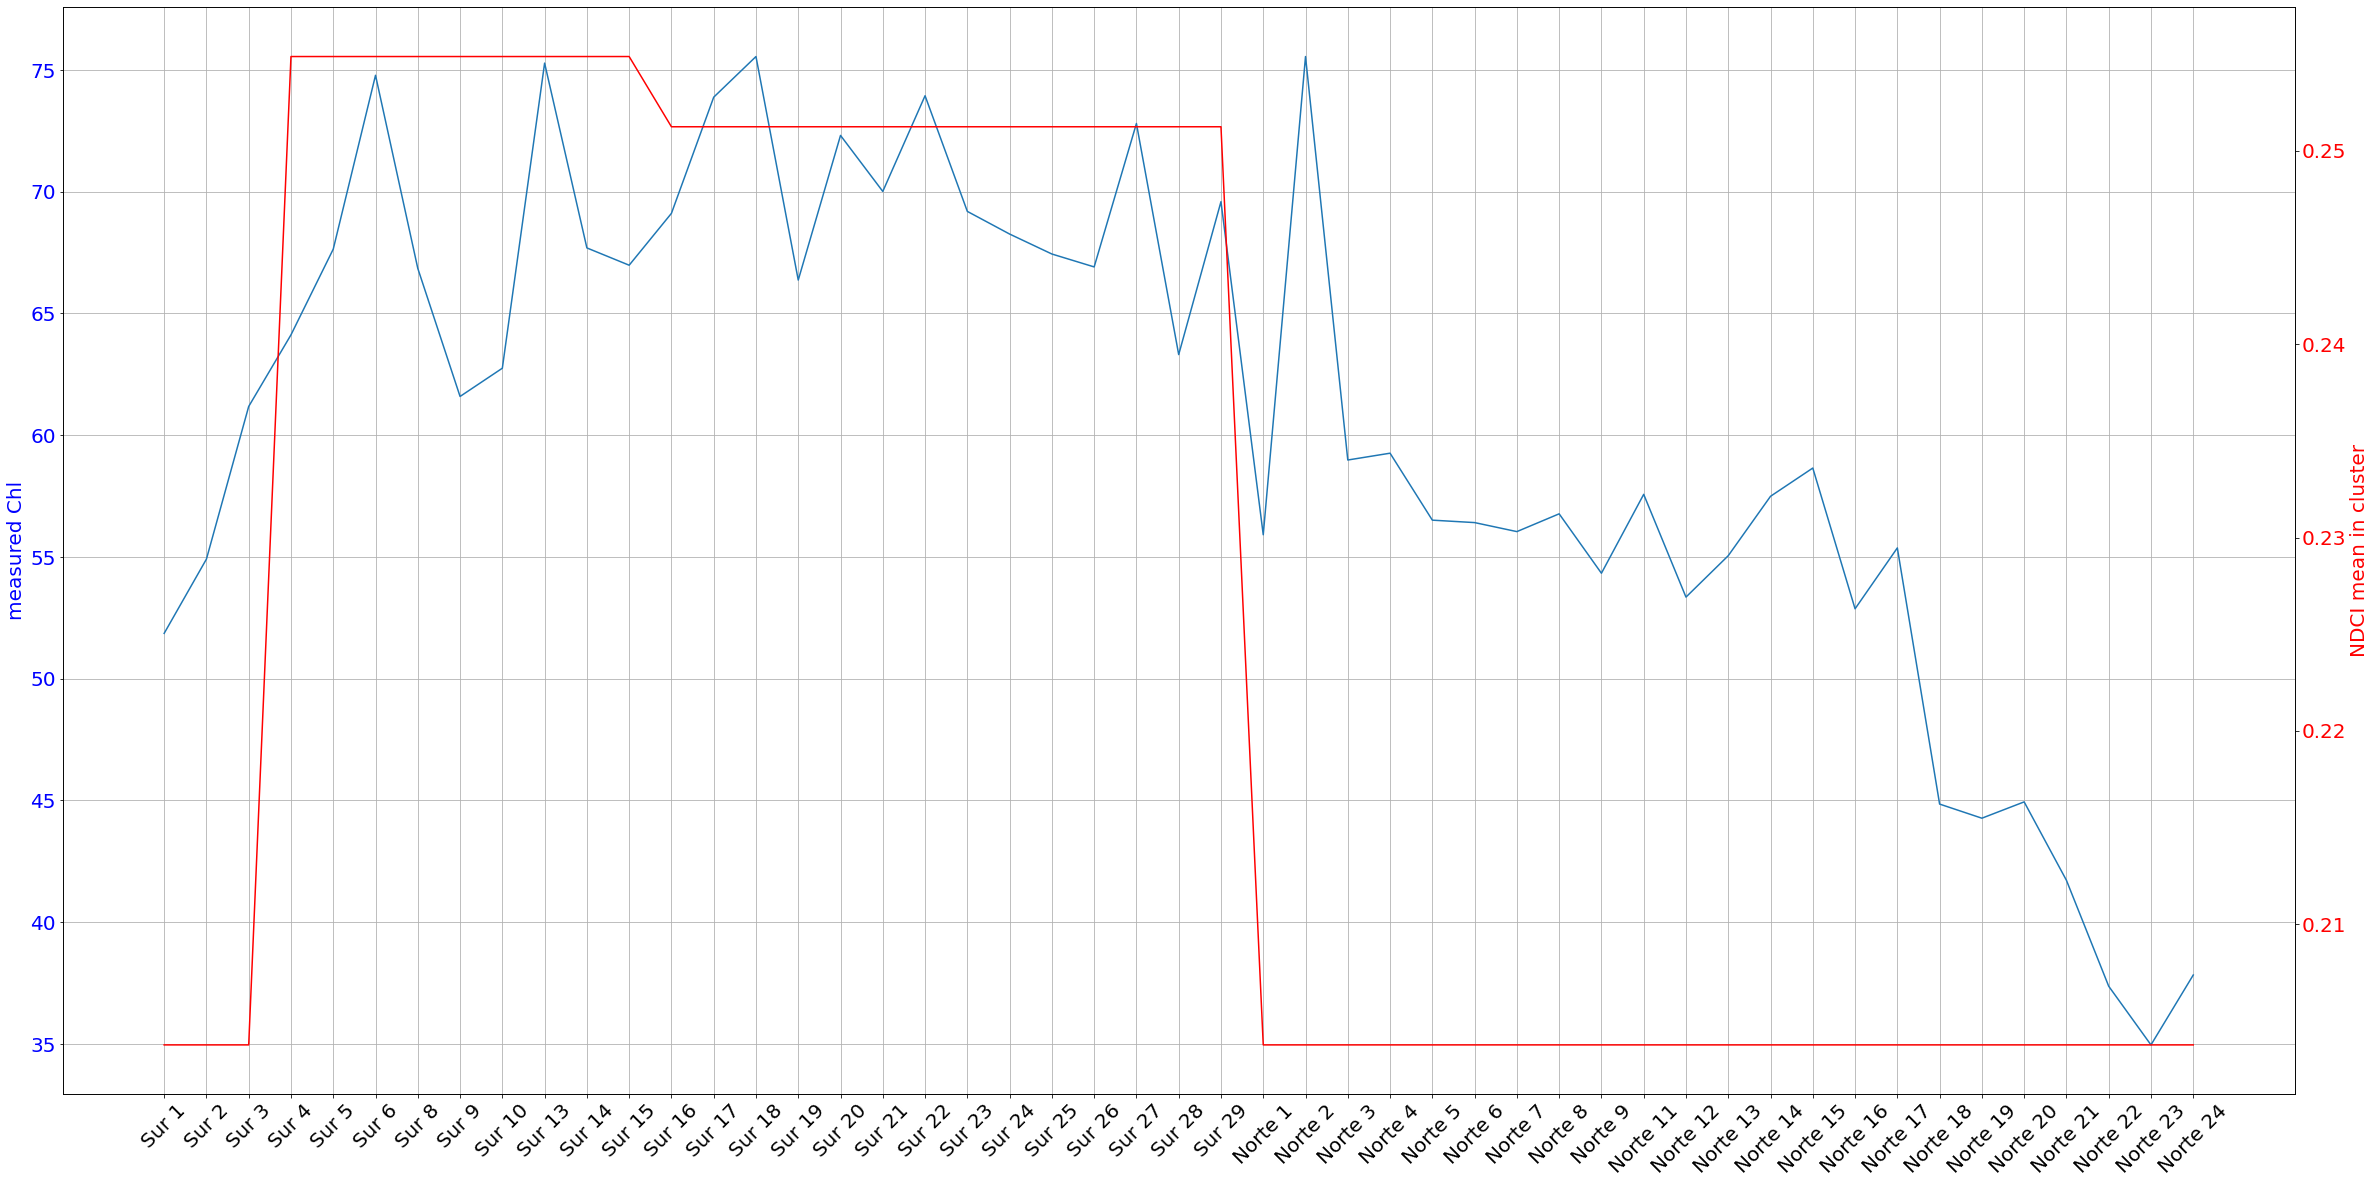

(0.7569281904429389, 3.123393498006782e-10)
(0.7523839348533311, 4.5674585410624923e-10)


In [44]:
fig = plt.figure(figsize=(40,20))
plt.grid()
ax1 = fig.add_subplot(111)
plt.yticks(fontsize=20)
ax1.plot(locations, gts)
ax1.set_ylabel('measured Chl', fontsize=20, color="b")
plt.xticks(fontsize=20, rotation=45)
ax2 = ax1.twinx()
plt.yticks(fontsize=20)
ax2.plot(locations, predicted, 'r-')
ax2.set_ylabel('NDCI mean in cluster', color='r', fontsize=20)
for tl in ax2.get_yticklabels():
    tl.set_color('r')
for tl in ax1.get_yticklabels():
    tl.set_color('b')
plt.show()
print(pearsonr(predicted, gts))
print(pearsonr(predicted_ndci, gts))

### Time series of NDCI mean

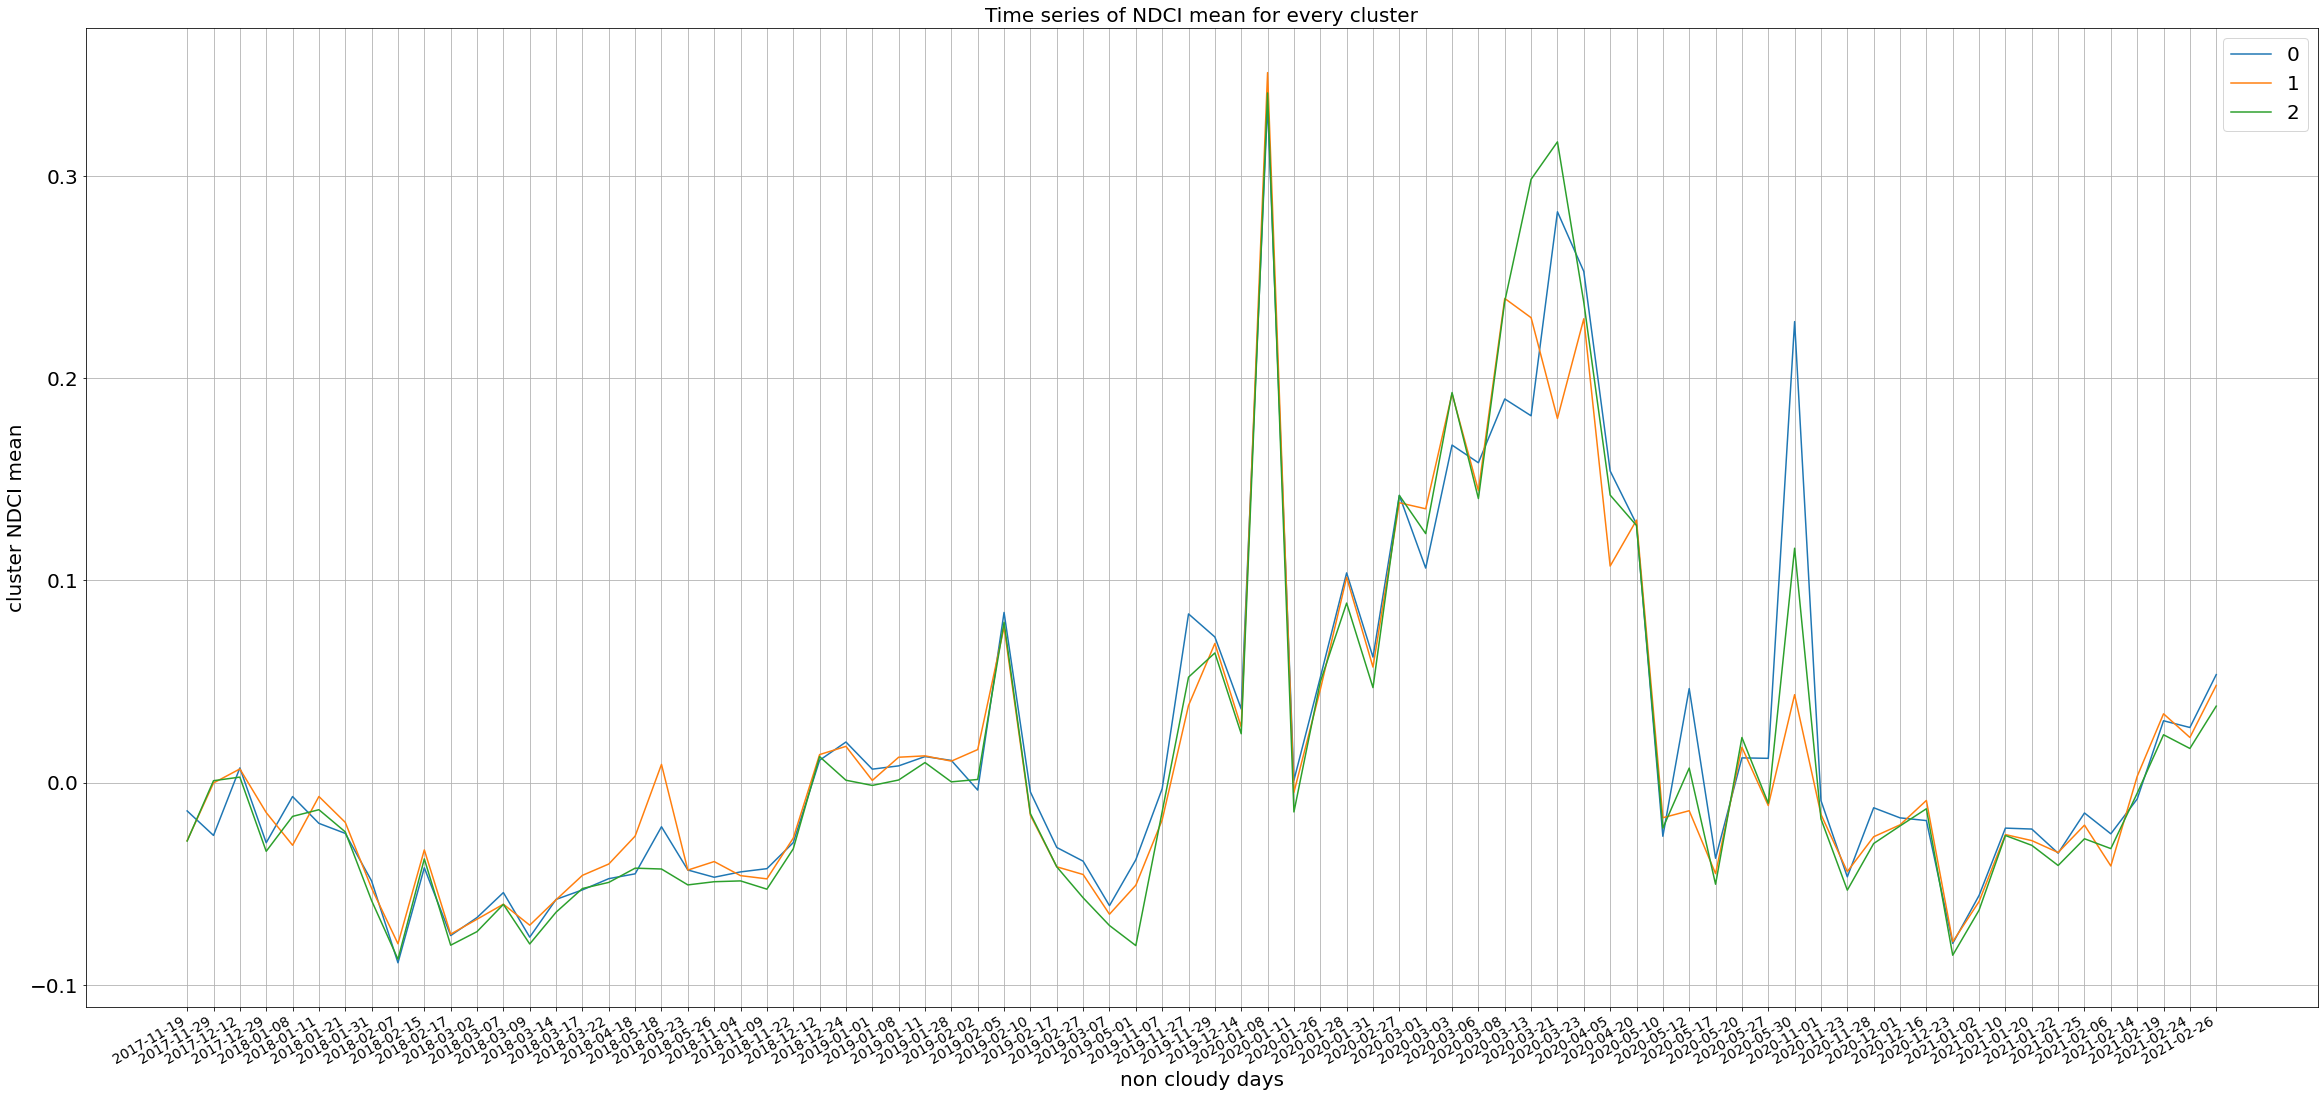

In [19]:
day_indexes = range(1, len(results)+1)
fig = plt.figure(figsize=(40,20))
for label in results_df["cluster"].unique():
    #label_means = [d[label]["mean"] for d in results]
    ndci_means = results_df[results_df["cluster"] == label]["mean_ndci"].tolist()
    dates = results_df[results_df["cluster"] == label]["date"].values
    dates = [str(d)[0:10] for d in dates]
    #label_stds = [d[label]["std"] for d in results]
    #plt.plot(day_indexes, label_means, label=str(label) + " mean")
    #plt.plot([d["date"] for d in results], label_means, label=str(label))
    plt.plot(dates, ndci_means, label=str(label))
    #plt.plot(day_indexes, label_stds, label=str(label) + " std")
    
plt.xlabel('non cloudy days', fontsize=20)
plt.xticks(np.arange(0, len(ndci_means), 1.0), fontsize=14)
# Set the y axis label of the current axis.
plt.ylabel('cluster NDCI mean', fontsize=20)
plt.yticks(fontsize=20)
# Set a title of the current axes.
plt.title('Time series of NDCI mean for every cluster', fontsize=20)
# put date in angle to read better
fig.autofmt_xdate()
# show a legend on the plot
plt.legend(fontsize=20)
plt.grid()
# save figure
#plt.savefig("test3.png", dpi=100, bbox_inches='tight')
# Display a figure.
plt.show()
#plt.close(fig)

### Operations with satellite data and empiric data

/home/enzo_tng/anaconda3/envs/cyano_venv/lib/python3.6/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  del sys.path[0]


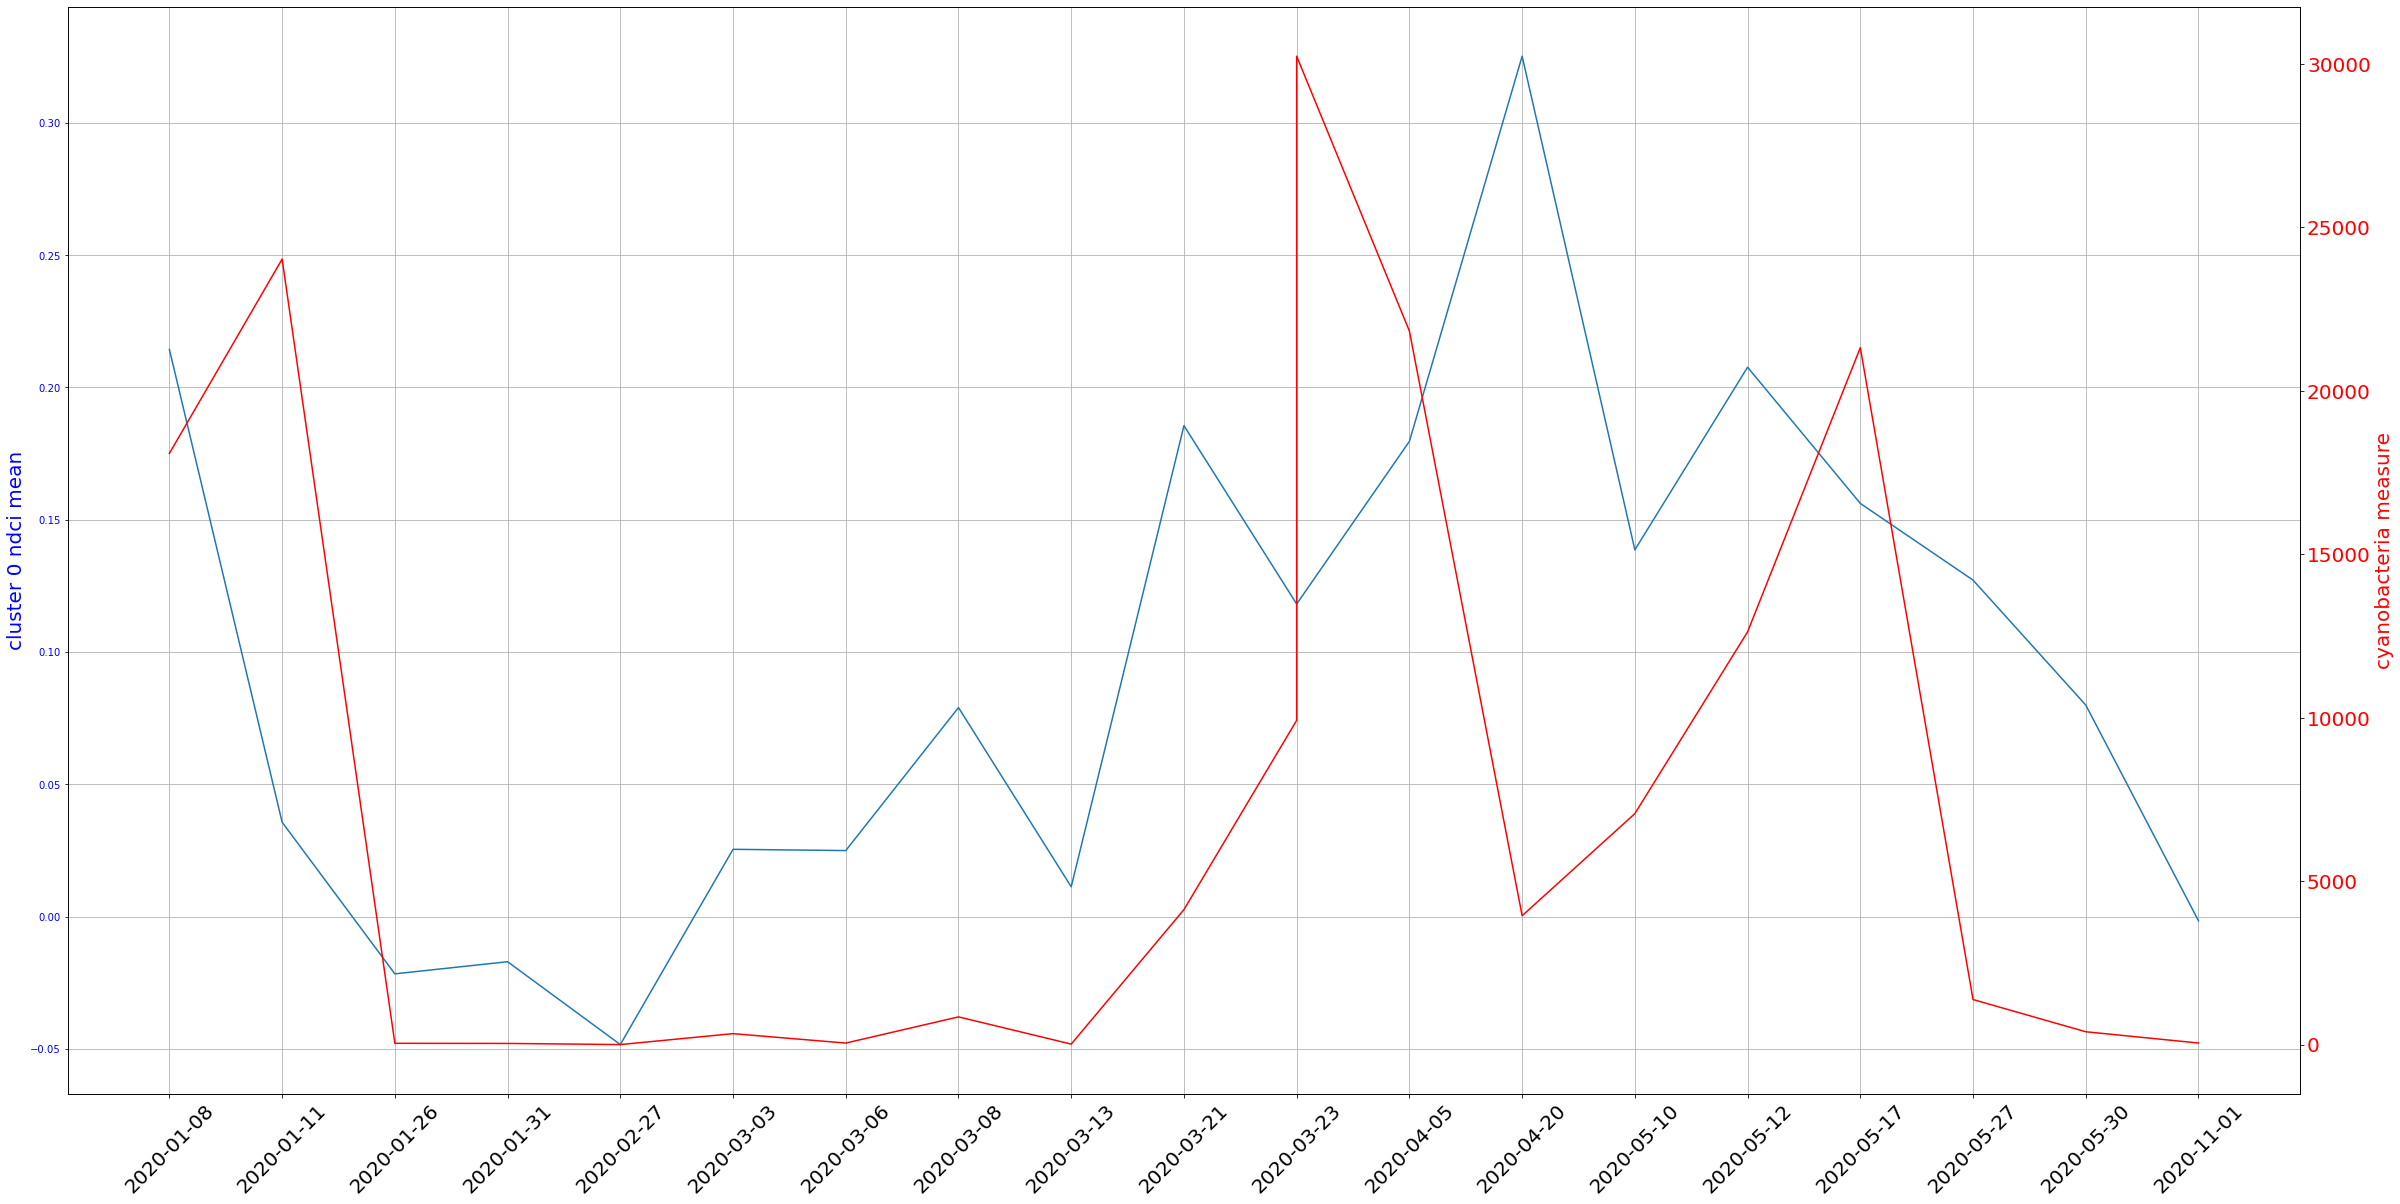

(0.40945526134762145, 0.07300750719127111)


/home/enzo_tng/anaconda3/envs/cyano_venv/lib/python3.6/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  del sys.path[0]


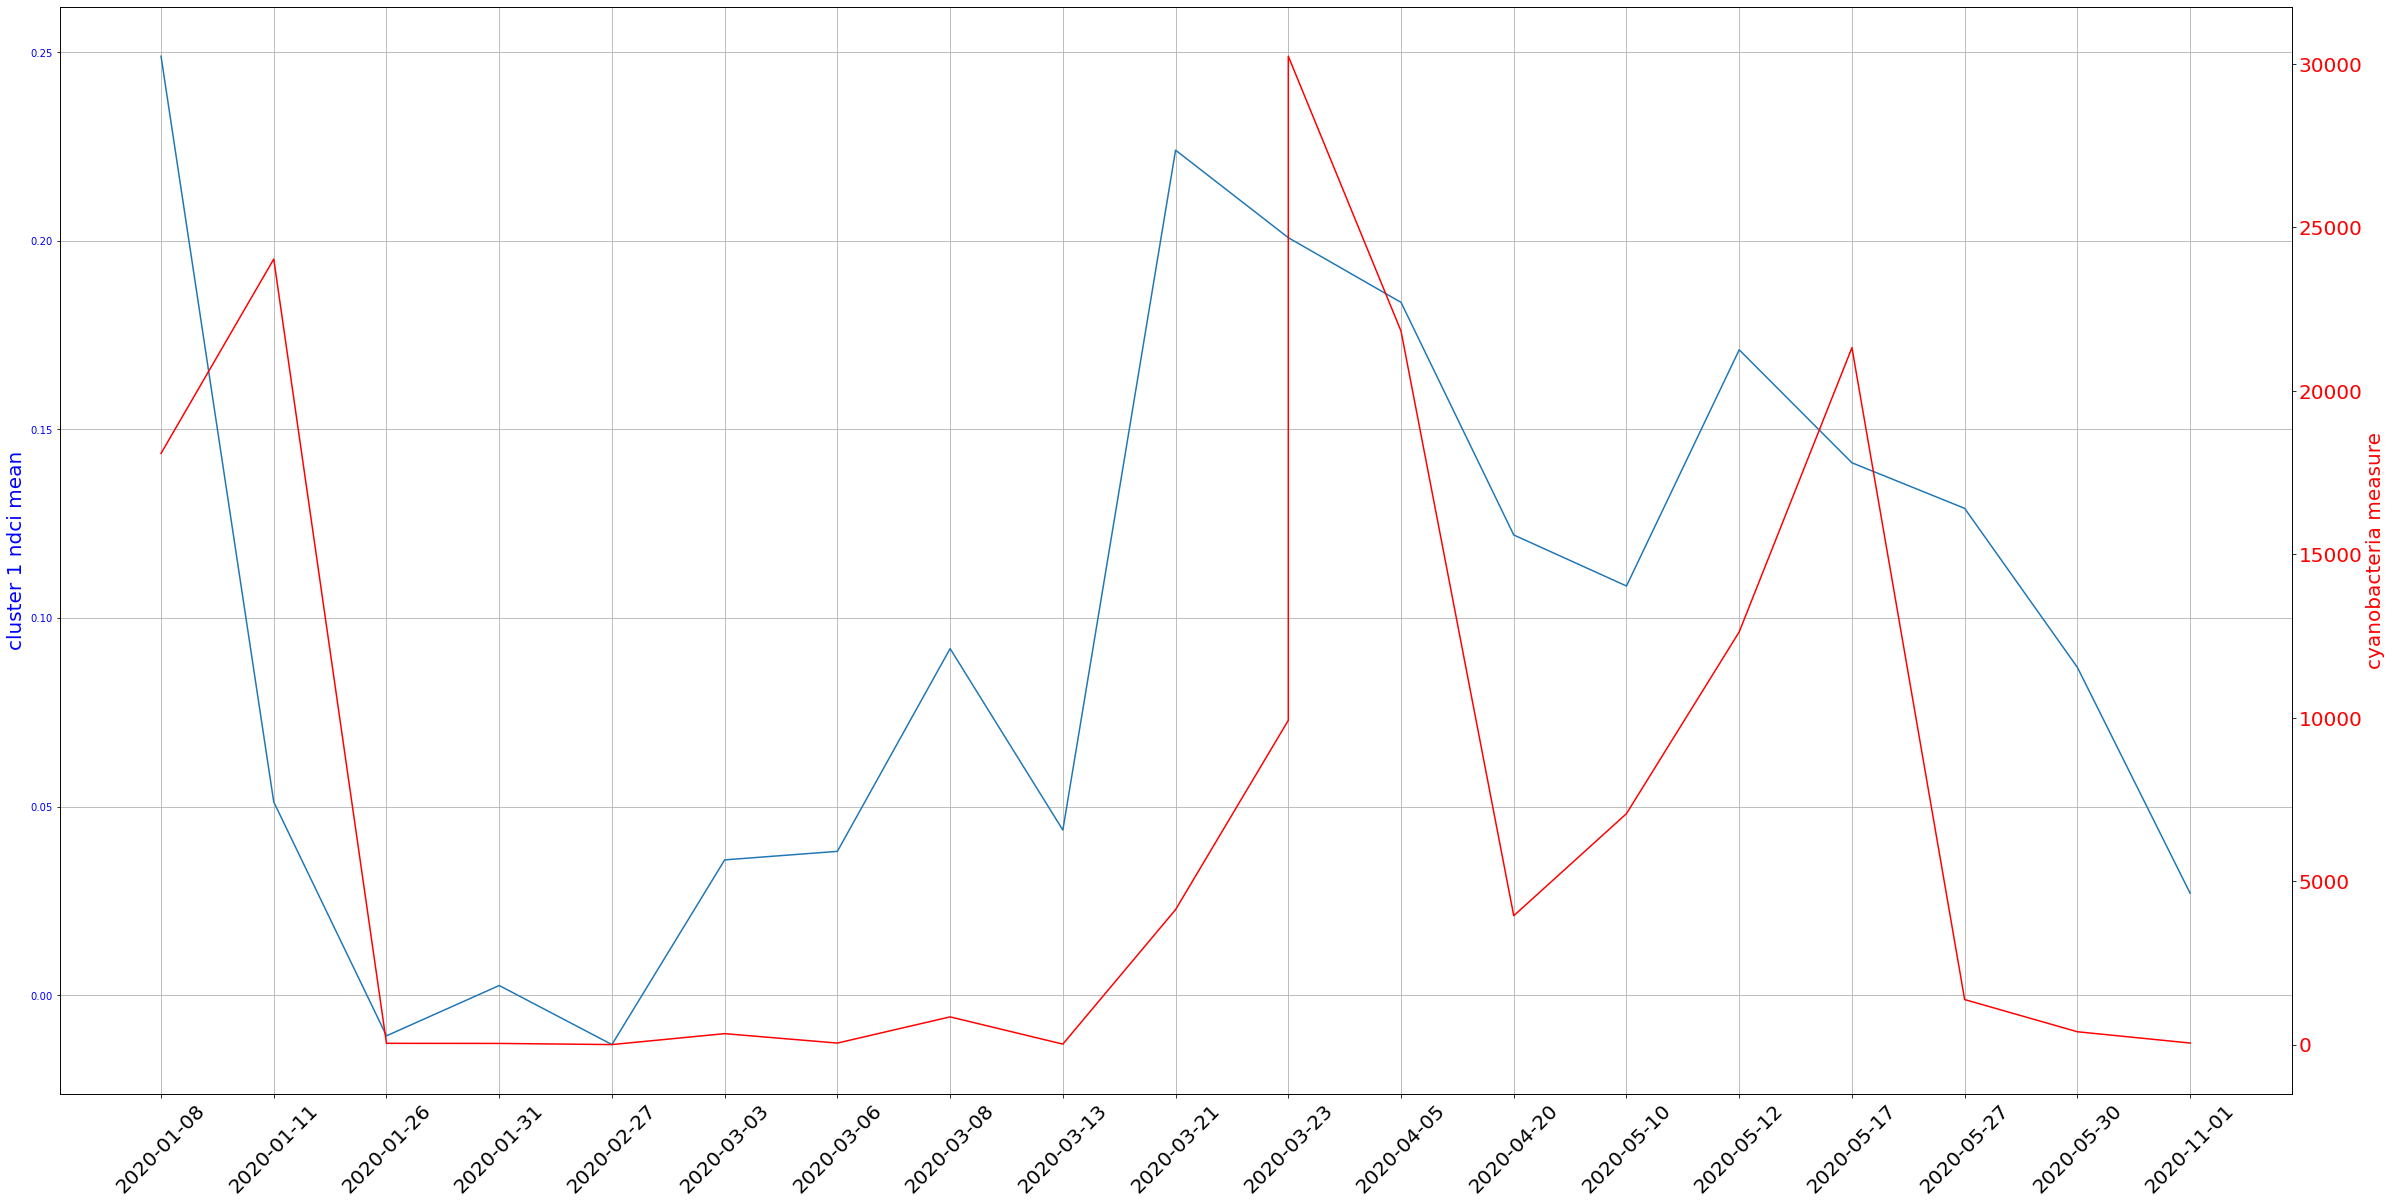

(0.5963950995834739, 0.005510962331019107)


/home/enzo_tng/anaconda3/envs/cyano_venv/lib/python3.6/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  del sys.path[0]


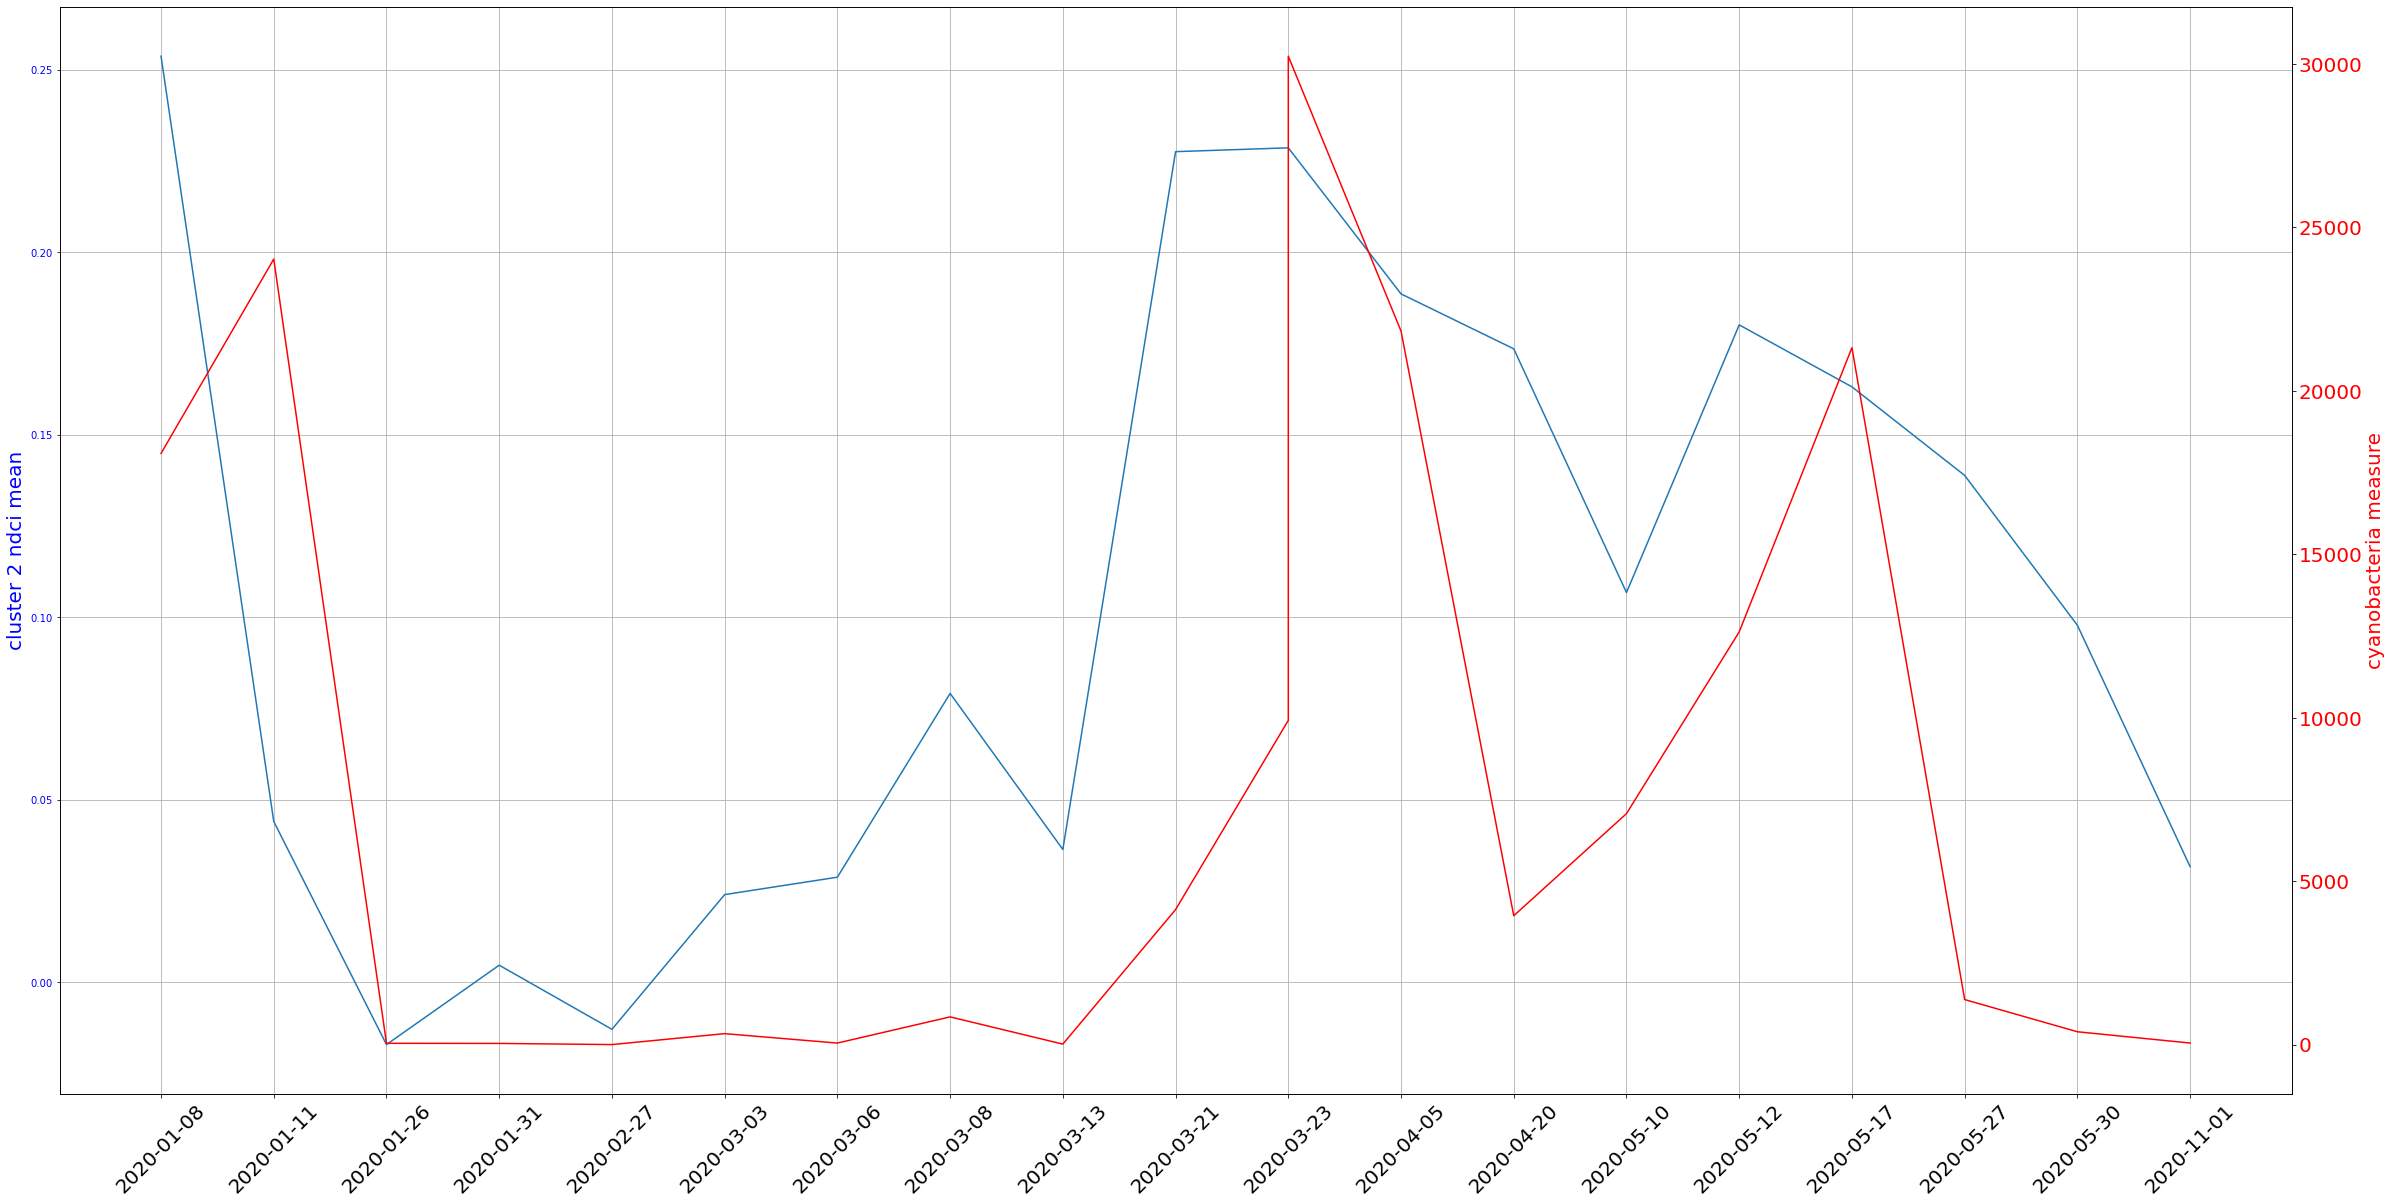

(0.5958220052054223, 0.005568030157322088)


In [127]:
from scipy.stats.stats import pearsonr

for i in [0,1,2]:
    cluster_df = results_df[results_df["cluster"] == i]

    common_data_df = cluster_df.merge(agua_data, left_on='date', right_on='date')
    dates = common_data_df["date"].values
    dates = [str(d)[0:10] for d in dates]
    cyanobacteria = common_data_df["cyanobacteria"].values
    ndci_means = common_data_df["mean_ndci"].values
    fig = plt.figure(figsize=(40,20))
    plt.grid()
    ax1 = fig.add_subplot(111)
    ax1.plot(dates, ndci_means)
    ax1.set_ylabel('cluster ' + str(i) + ' ndci mean', fontsize=20, color="b")
    plt.xticks(fontsize=20, rotation=45)
    ax2 = ax1.twinx()
    ax2.plot(dates, cyanobacteria, 'r-')
    ax2.set_ylabel('cyanobacteria measure', color='r', fontsize=20)
    for tl in ax2.get_yticklabels():
        tl.set_color('r')
    for tl in ax1.get_yticklabels():
        tl.set_color('b')
    plt.yticks(fontsize=20)
    plt.show()

    print(pearsonr(ndci_means, cyanobacteria))

### Time series of every cluster mean and std

No handles with labels found to put in legend.


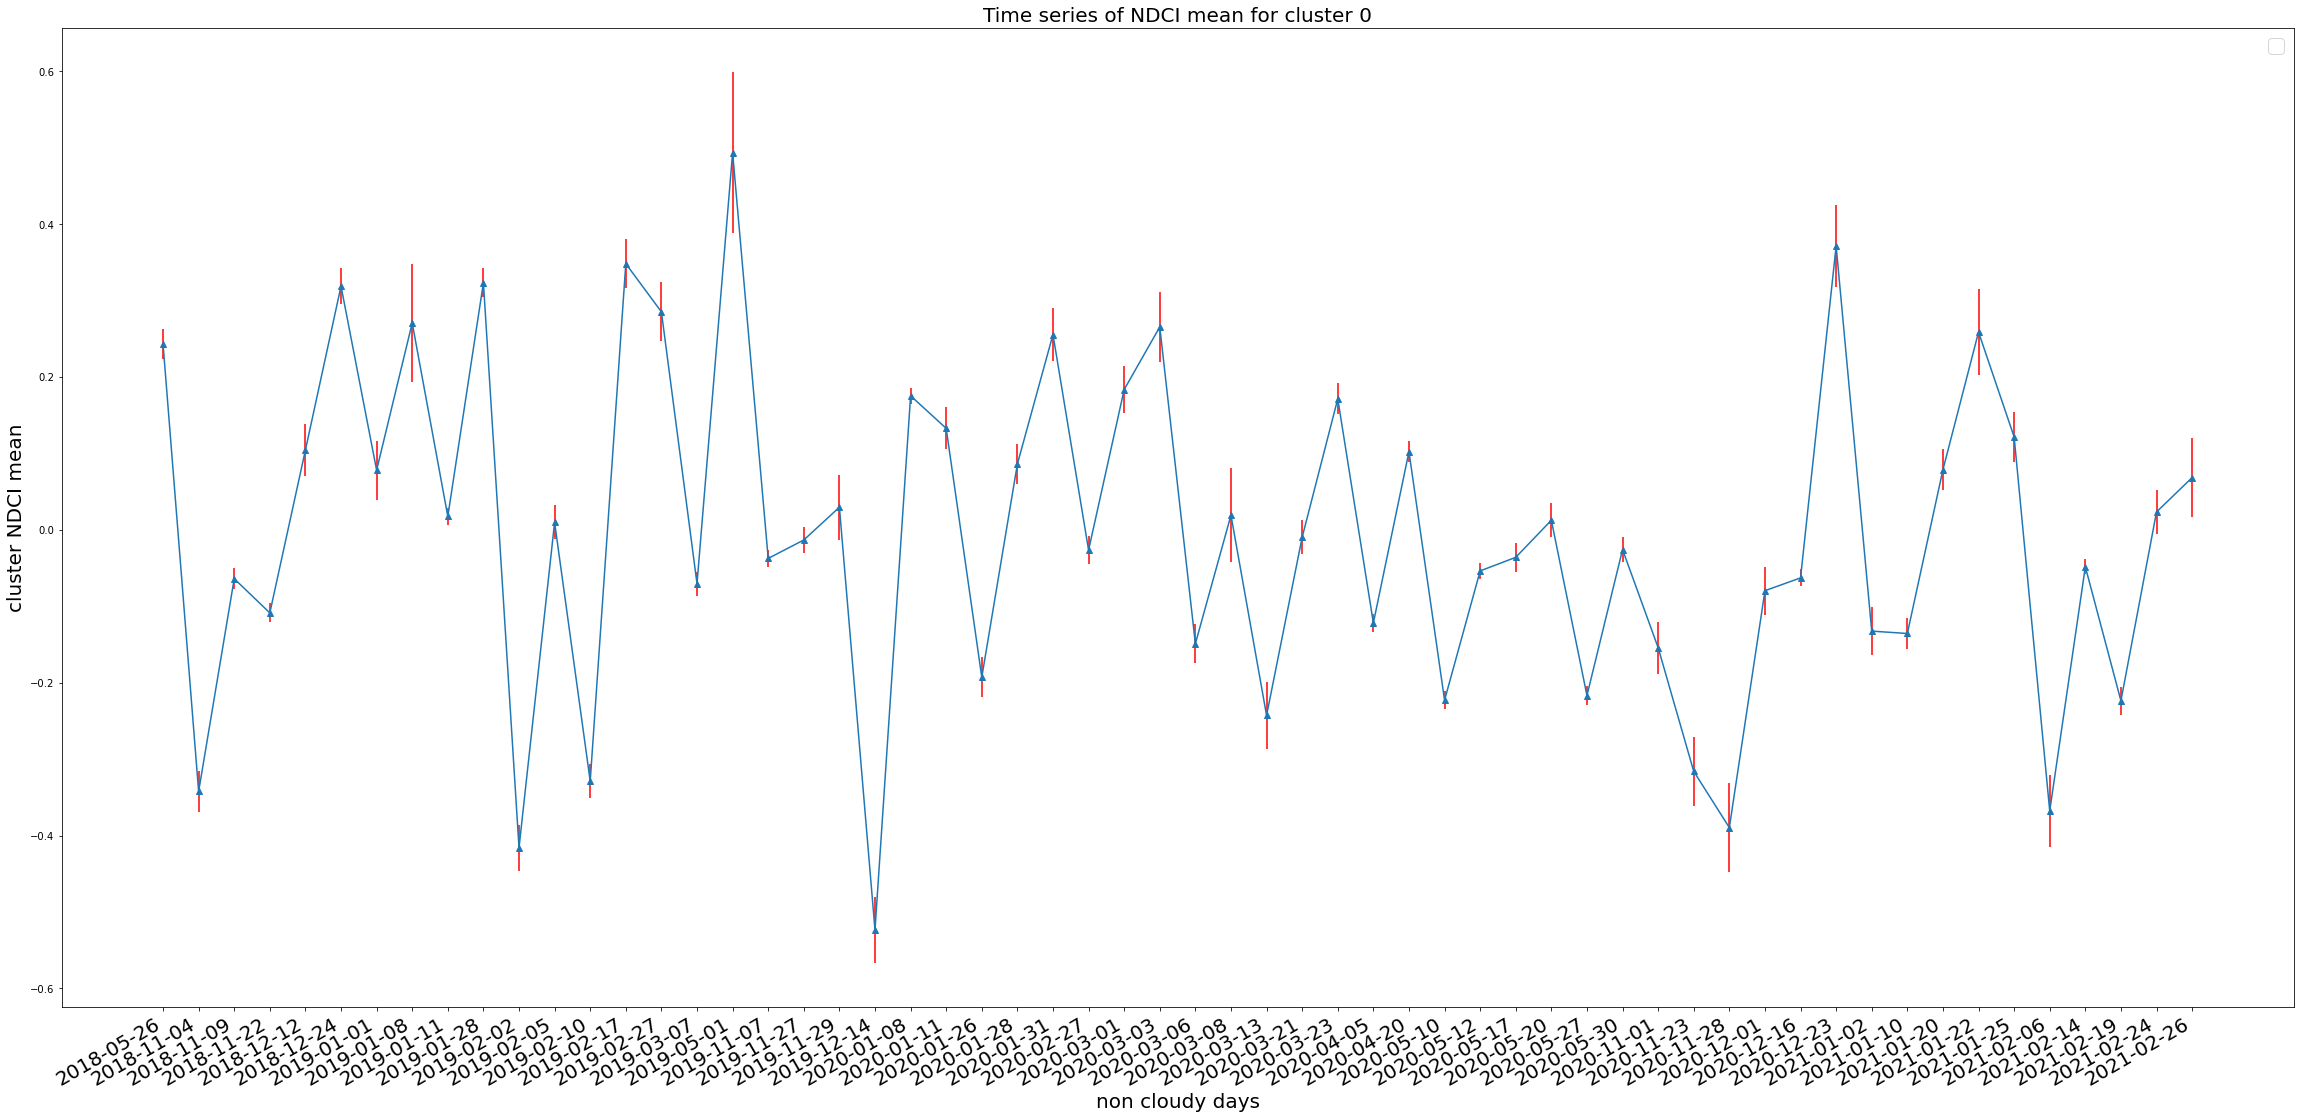

No handles with labels found to put in legend.


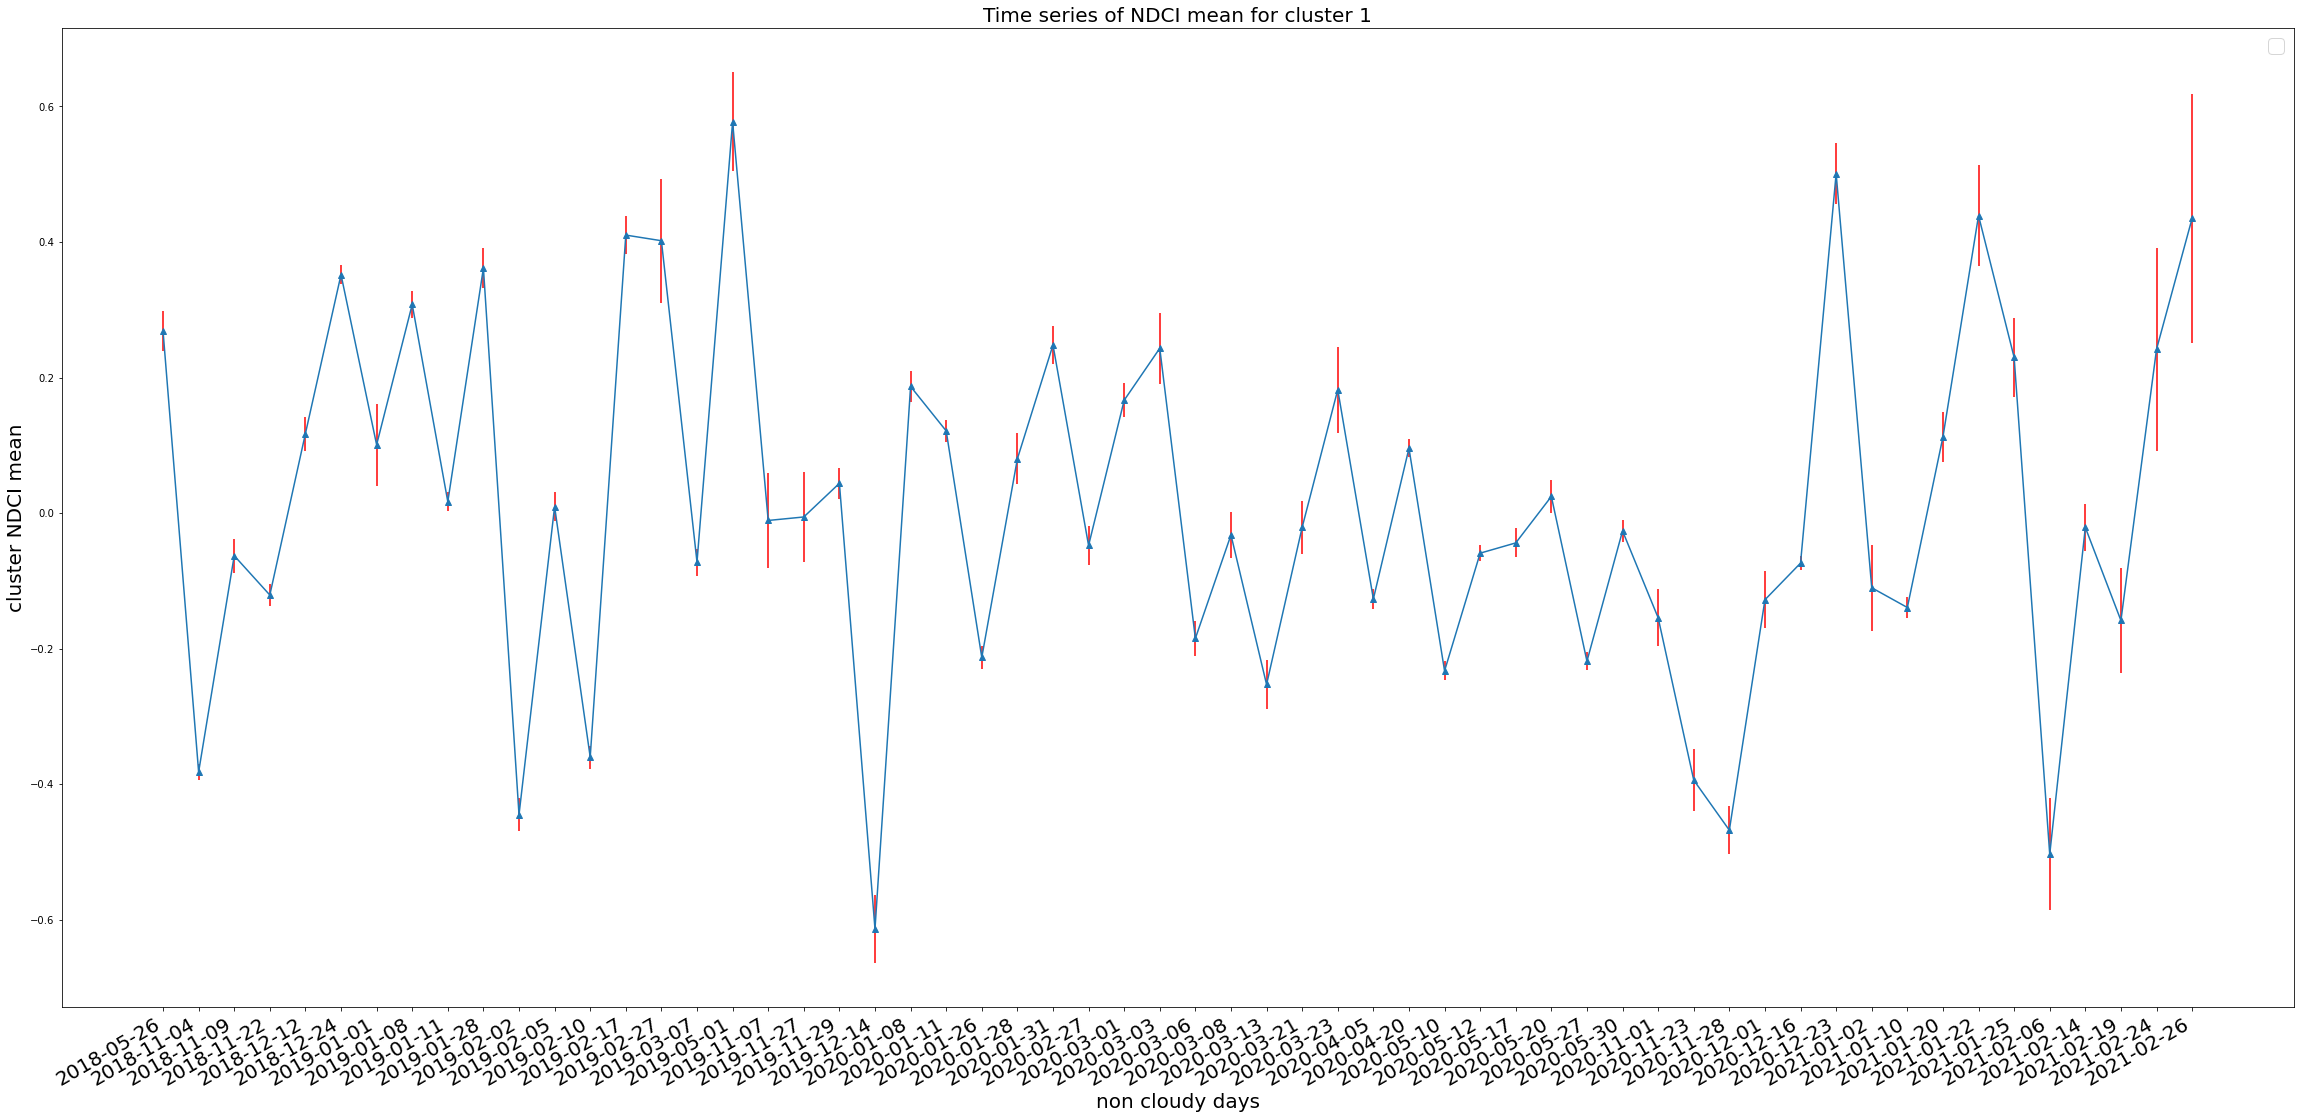

No handles with labels found to put in legend.


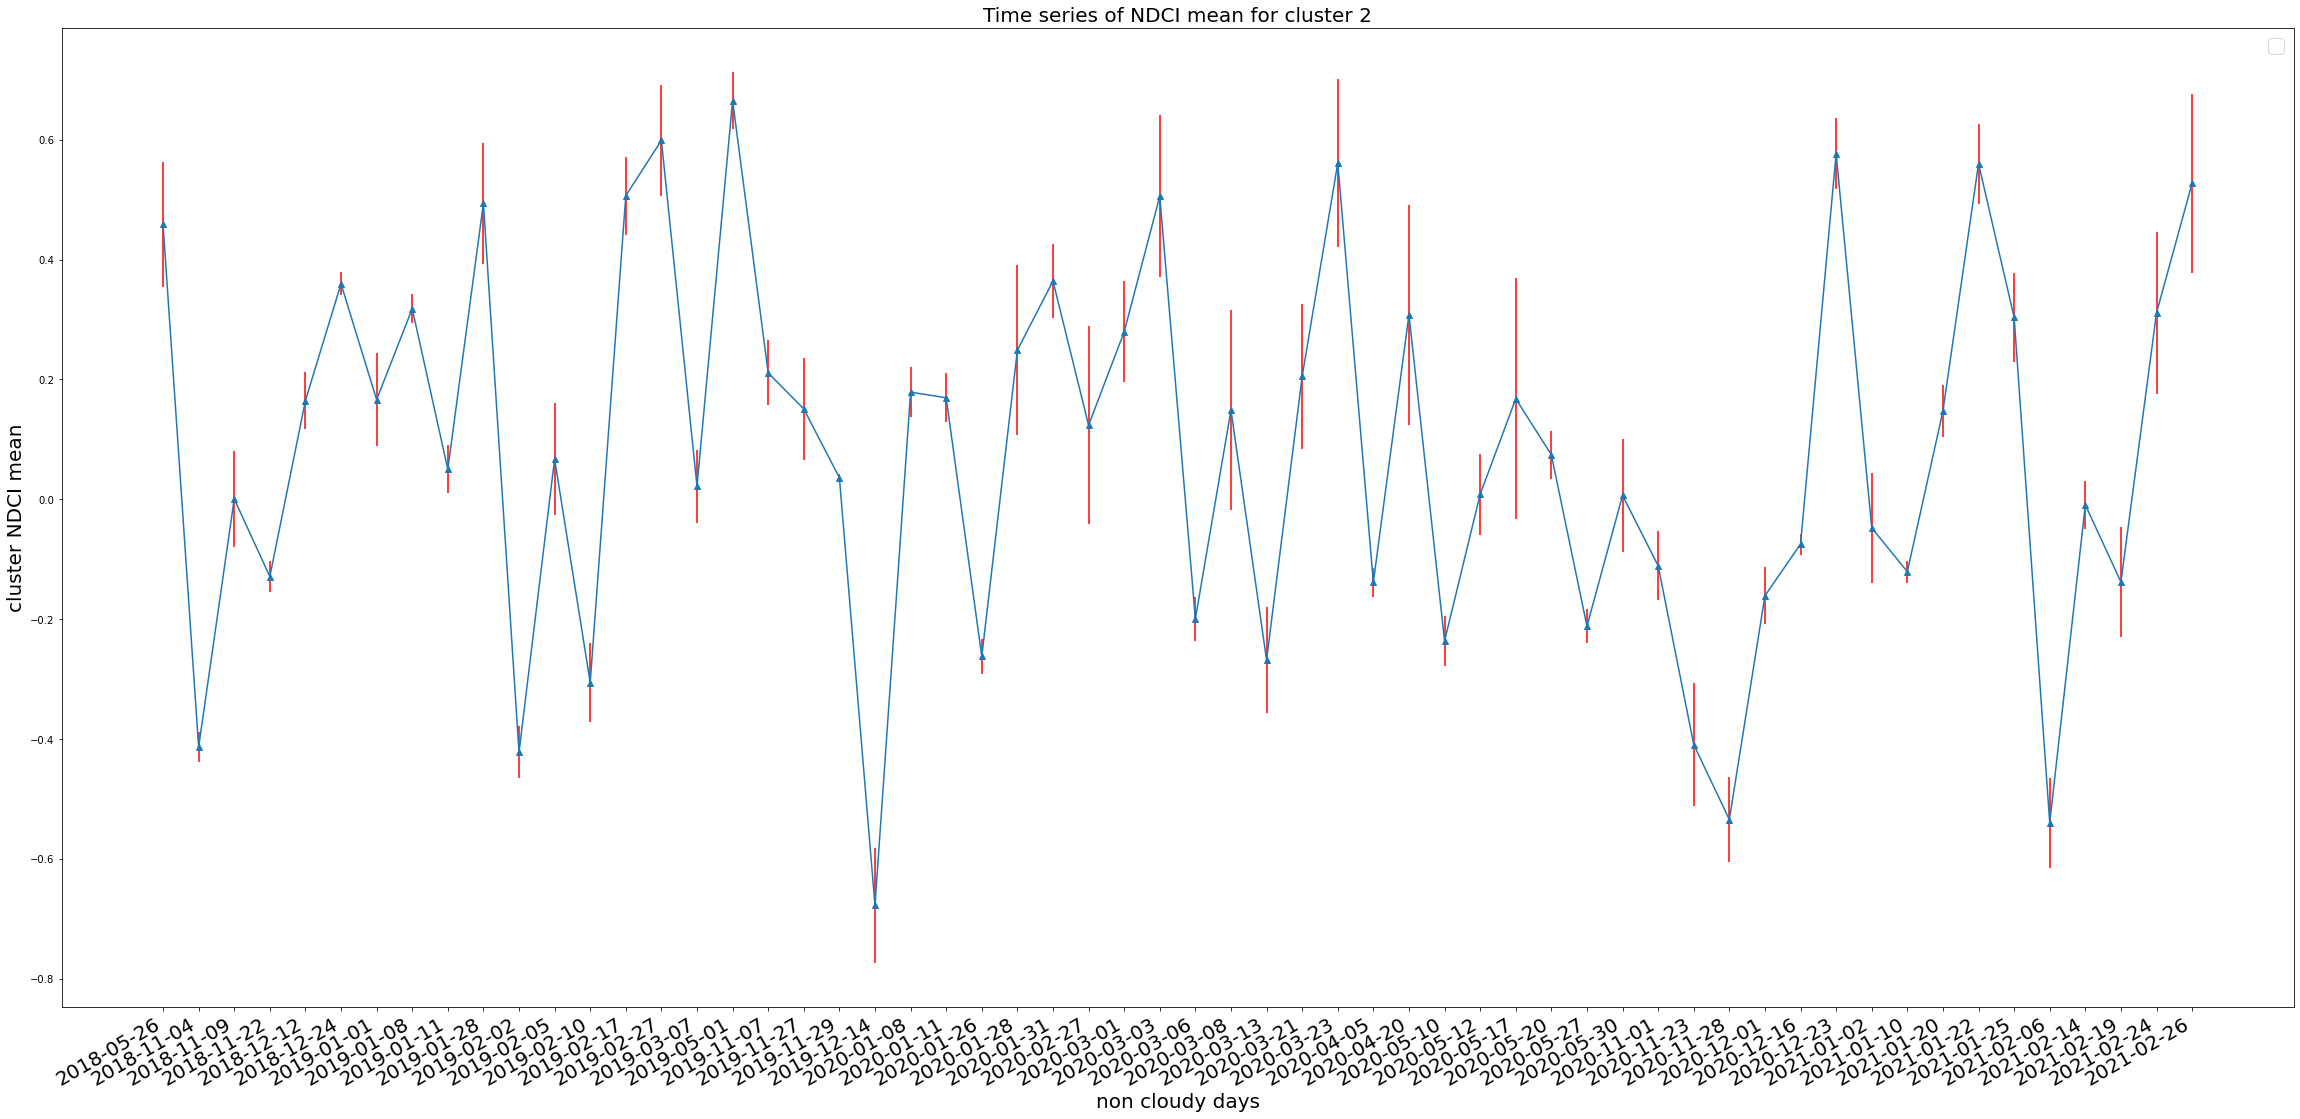

In [30]:
import matplotlib.pyplot as plt

for cluster_label in unique_labels:
    fig = plt.figure(figsize=(40,20))
    label_means = [d[cluster_label]["mean"] for d in results]
    label_stds = [d[cluster_label]["std"] for d in results]
    #plt.plot(day_indexes, label_means, label=str(label) + " mean")
    #plt.errorbar([d["date"] for d in results], label_means, label_stds, linestyle='None', marker='^')
    plt.errorbar([d["date"] for d in results], label_means, label_stds, marker='^', ecolor="red")
    #plt.plot([d["date"] for d in results], label_means, label=str(cluster_label))
    #plt.plot(day_indexes, label_stds, label=str(cluster_label) + " std")

    plt.xlabel('non cloudy days', fontsize=20)
    plt.xticks(np.arange(0, len(results), 1.0), fontsize=20)
    # Set the y axis label of the current axis.
    plt.ylabel('cluster NDCI mean', fontsize=20)
    # Set a title of the current axes.
    plt.title('Time series of NDCI mean for cluster ' + str(cluster_label), fontsize=20)
    # put date in angle to read better
    fig.autofmt_xdate()
    # show a legend on the plot
    plt.legend(fontsize=20)
    # save figure
    #plt.savefig("test3.png", dpi=100, bbox_inches='tight')
    # Display a figure.
    plt.show()
    #plt.close(fig)

### Visualize rgb from day in particular

2021-02-26


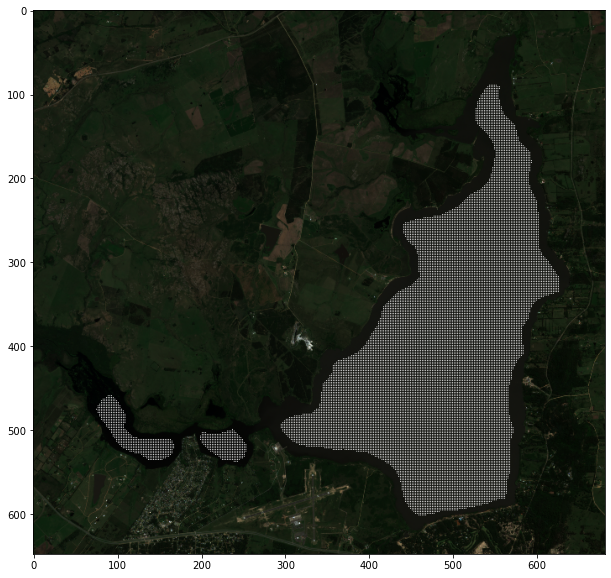

In [21]:
#DATE = "2021-01-25"
DATE = results[-1]["date"]
print(DATE)

day_data = DayData(os.path.join(settings.data_path, DATE, "acolite_output"))
fig = plt.figure(figsize=(20,10))
#plt.imshow(day_data.rgb)
plt.imshow(mask.display_mask_img(day_data.rgb))
plt.show()

### Compress directorys with results

In [ ]:
#!tar -zcvf K-means.tar.gz K-means
#!tar -zcvf Agglomerative.tar.gz Agglomerative_clustering
#!tar -zcvf Spectral.tar.gz Spectral